# Association between omics support and target clinical success

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import json

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils
import upsetplot

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
def _palette_df_from_dict(palette_dict):
    palette_df = pd.DataFrame(palette_dict.values(), index=palette_dict.keys())
    palette_df.columns = ['color']
    return(palette_df)
    
## Gene classes 
GENE_CLASS_ORDER = ['nuclear_receptors', 'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases', 'enzymes', 'ion_channels', 'other']
gene_class_palette = {
    x:sns.color_palette('Set1').as_hex()[i] if x != 'other' else sns.color_palette('Set1').as_hex()[-1] for i,x in enumerate(GENE_CLASS_ORDER)
}
gene_class_palette_df = _palette_df_from_dict(gene_class_palette)

In [9]:
%%R -i gene_class_palette_df -i figdir
gene_class_palette <- setNames(gene_class_palette_df$color, rownames(gene_class_palette_df))

# utils
ggsave_figdir <- function(output_name, width, height){
    ggsave(paste0(figdir, output_name, '.png'), width = width, height = height) 
    ggsave(paste0(figdir, output_name, '.pdf'), width = width, height = height)
}


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [10]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [11]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [84]:
universe_dict.keys()

dict_keys(['protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets'])

In [86]:
annos.keys()

dict_keys(['nuclear_receptors', 'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases', 'enzymes', 'ion_channels'])

In [140]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "cell type & disease marker", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "disease marker", 
    "ct_marker_evidence" = "Cell type marker", 
    "has_genetic_support" = "GWAS association"
    )

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets",
    'known_drug_targets' = 'known drug targets\n(reached phase I)',
    'nuclear_receptors' = 'nuclear receptors', 
    'catalytic_receptors' = 'catalytic receptors', 
    'rhodop_gpcr' = 'rhodopsin-like\nGPCRs', 
    'transporters' = 'transporters', 
    'kinases' = 'kinases', 
    'enzymes' = 'enzymes', 
    'ion_channels' = 'ion channels'
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    base_font_size=20,
    text_position='right',
    y_value = 'clinical_status',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease'),
    clinical_status_levels = c(rev(c('druggable', 'safe', 'effective', 'approved')))
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=clinical_status_levels)) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        rename(setNames(y_value,'y_val'))
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=y_val, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -1) , 
                  size=5,
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Drug target class') +
        theme_classic(base_size=base_font_size) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

## Reproducing association with genetics evidence

In [14]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

Get dictionary for all the universes (to use when the same universe is used for all diseases)

In [55]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

Get dictionary of target classes

In [61]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()
    annos[anno_name] = np.unique(annos[anno_name])

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['A2M', 'AADAT', 'AAK1', ..., 'ZNF217', 'ZNF692', 'ZUP1'],
      dtype=object)

### Compute OR with different universe of targets

- All protein-coding genes
- All targets with known drugs for the considered diseases
- All small-molecule tractable targets
- All antibody-tractable targets

In [15]:
## Get all disease IDs in scRNA-seq data
# all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_OT_targets.h5ad')]
all_disease_ids = pd.read_csv('../data/all_diseases_postqc.csv')['disease_ontology_id'].tolist()

In [16]:
len(all_disease_ids)

30

Run association testing

In [34]:
results_genetics_df = pd.DataFrame()
genetics_all_df = OT_targets_df.copy()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'all_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
        or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'cxg_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [65]:
genetics_all_df.disease_ontology_id.nunique()

15075

In [35]:
# Variable universe x disease cases
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    ## Known drug OT targets
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.known_drug > 0], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[(genetics_all_df.known_drug > 0) & (genetics_all_df.disease_ontology_id.isin(all_disease_ids))], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [64]:
results_genetics_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,disease_ontology_id,universe
0,13.039982,12.197163,13.926235,0.000000e+00,56568.0,295322532.0,906.0,369075.0,has_genetic_support,is_safe,all_diseases,protein_coding_targets
0,3.427745,2.643661,4.376804,7.886609e-17,2840.0,585760.0,67.0,4167.0,has_genetic_support,is_safe,cxg_diseases,protein_coding_targets
0,16.691700,15.409969,18.052822,0.000000e+00,31338.0,295347762.0,640.0,369075.0,has_genetic_support,is_effective,all_diseases,protein_coding_targets
0,3.635390,2.583014,4.981976,1.869503e-11,1594.0,587006.0,40.0,4167.0,has_genetic_support,is_effective,cxg_diseases,protein_coding_targets
0,26.413403,23.773552,29.271427,0.000000e+00,11797.0,295367303.0,377.0,369075.0,has_genetic_support,is_approved,all_diseases,protein_coding_targets
0,5.944184,3.772494,8.947566,1.805690e-11,593.0,588007.0,24.0,4167.0,has_genetic_support,is_approved,cxg_diseases,protein_coding_targets
0,11.861760,11.071460,12.694229,0.000000e+00,55367.0,90714533.0,855.0,120647.0,has_genetic_support,is_safe,all_diseases,sm_tractable_targets
0,3.256507,2.475654,4.214869,1.493828e-14,2775.0,193725.0,62.0,1412.0,has_genetic_support,is_safe,cxg_diseases,sm_tractable_targets
0,15.460814,14.252351,16.745703,0.000000e+00,30846.0,90739054.0,619.0,120647.0,has_genetic_support,is_effective,all_diseases,sm_tractable_targets
0,3.572242,2.519011,4.931288,6.545483e-11,1578.0,194922.0,39.0,1412.0,has_genetic_support,is_effective,cxg_diseases,sm_tractable_targets


In [44]:
%%R -i results_genetics_df -h 400 -w 1700 -i figdir
results_genetics_df %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets', 'known_drug_targets'))) %>%
    drop_na() %>%
    plot_OR(text_position='right') +
    expand_limits(x=50) +
    facet_grid(disease_ontology_id~universe) +
    ggsave(paste0(figdir, 'OR_genetics.png'), height=4, width=20)
    ggsave(paste0(figdir, 'OR_genetics.pdf'), height=4, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Get single-cell support from DE results and merge with OT evidence 

In [149]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    DE2evidence_celltype_params = {"lfc_thresh":1.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":1.0, 'lfc_group':'all'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict.update(disease_evidence)
    evidence_dict['is_hvg_normal'] = ct_res.gene_id.unique()
    evidence_dict['is_hvg_disease'] = disease_res.gene_id.unique()
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [572]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]
all_disease_ids = [x for x in all_disease_ids if x.startswith("MONDO")]

In [598]:
## Save evidence results for each disease
targets_evidence_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_all = pd.concat([targets_evidence_all, targets_disease_df], axis=0)
    targets_disease_df.to_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv')

targets_evidence_all['any'] = (targets_evidence_all[['ct_marker_evidence', 'disease_ct_evidence', 'has_genetic_support']].sum(1) > 0).astype('int')

missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0018874
missing MONDO_0001056
missing MONDO_0024885
missing MONDO_0024660


#### Annotate target class

In [884]:
targets_evidence_all = pd.merge(targets_evidence_all, ens_ids_to_name, how='left')
for k,a in annos.items():
    targets_evidence_all[f'is_{k}'] = targets_evidence_all.gene_name.isin(a).astype('int')

gene_group_cols = [f'is_{k}' for k in annos.keys()]
targets_evidence_all['gene_class'] = np.where(
    targets_evidence_all[gene_group_cols].sum(1) > 0,
    targets_evidence_all[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )
    

In [890]:
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

## Association statistics

Collect evidence and clinical status for all tested diseases.

In [46]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv', index_col=0)

## Clean table for supplementary table
st_targets_evidence_all = targets_evidence_all[[
    'gene_id', 'disease_ontology_id','disease',
    'disease_relevant_tissue', 'gene_name', 'gene_class',
    'genetic_association', 'known_drug', 'is_druggable', 'is_safe',
    'is_effective', 'is_approved', 'has_genetic_support',
    'ct_marker_evidence', 'disease_evidence', 'all_sc_evidence', 'bulk_disease_evidence',
    'disease_ct_evidence']]

rename_cols = {
    'OT_genetic_association': 'known_drug',
    'OT_known_drug': 'known_drug',
    'has_genetic_support': 'GWAS_evidence',
    'all_sc_evidence':'ct_marker_and_disease_evidence',
    'bulk_disease_evidence': 'disease_evidence_tissue',
    'disease_ct_evidence': 'disease_evidence_celltype'
} 

st_targets_evidence_all = st_targets_evidence_all.rename(rename_cols, axis=1)
st_targets_evidence_all.index = st_targets_evidence_all.gene_id.astype('str') + "_" + st_targets_evidence_all.disease_ontology_id.astype('str')
assert not st_targets_evidence_all.index.duplicated().any()

st_targets_evidence_all.to_csv(data_dir + 'suppl_table_disease_target_evidence.csv')

In [50]:
targets_evidence_all[['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']].sum()

ct_marker_evidence     33654.0
disease_evidence       60851.0
has_genetic_support     4175.0
dtype: float64

In [51]:
targets_evidence_all[['is_safe', 'is_effective', 'is_approved']].sum()

is_safe         2925.0
is_effective    1646.0
is_approved      601.0
dtype: float64

In [52]:
# Check number of diseases 
print(f"Tot. no of diseases considered: {targets_evidence_all['disease_ontology_id'].nunique()}")

Tot. no of diseases considered: 30


In [53]:
targets_evidence_all[['disease_ontology_id','disease']].drop_duplicates().to_csv('../data/all_diseases_postqc.csv')

In [58]:
universe_df = pd.concat([pd.DataFrame(v, columns=[k]).melt(var_name='universe', value_name='gene_ids') for k,v in universe_dict.items()])
universe_df.to_csv('../data/universe_genes.csv')

Compute odds-ratios for all diseases together with different universes

In [67]:
results_all_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [68]:
annos_ensids = {}
for k, gs in annos.items():
    gs_keep = gs[pd.Series(gs).isin(ens_ids_to_name.gene_name)]
    annos_ensids[k] = ens_ids_to_name.set_index('gene_name').loc[gs_keep].values.flatten().tolist()

In [69]:
OR_class_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for u_name, u_list in annos_ensids.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in [ 'ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            OR_class_df = pd.concat([OR_class_df, or_df], axis=0)

In [70]:
known_drug_targets_all = OT_targets_df[
    OT_targets_df['known_drug'] > 0.05 # reaching at least phase I
].gene_id.unique().tolist()

known_drug_or_df = pd.DataFrame()
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['ct_marker_evidence', 'disease_evidence', 'all_sc_evidence','has_genetic_support']:
        ## All OT targets
        or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=known_drug_targets_all)
        or_df['universe'] = 'known_drug_targets'
        or_df['universe_size'] = len(known_drug_targets_all)
        known_drug_or_df = pd.concat([known_drug_or_df, or_df])

In [71]:
results_all_df = pd.concat([results_all_df, OR_class_df, known_drug_or_df])

In [80]:
## Save for supplementary figure
st_results_all_df = results_all_df[~results_all_df.evidence.isin(['is_hvg_normal', 'is_hvg_disease'])]
st_results_all_df.to_csv('../data/suppl_table_odds_ratios.all.csv')

Test within HVGs

In [173]:
hvgs_or_df = pd.DataFrame()
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['ct_marker_evidence', 'disease_evidence']:
        if ev == 'ct_marker_evidence':
            test_df = targets_evidence_all[targets_evidence_all.is_hvg_normal==1].copy()
        elif ev == 'disease_evidence':
            test_df = targets_evidence_all[targets_evidence_all.is_hvg_disease==1].copy()
        or_df = association_utils.get_OR(test_df, ev, ot_ev)
        or_df['universe'] = 'HVGs'
        hvgs_or_df = pd.concat([hvgs_or_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


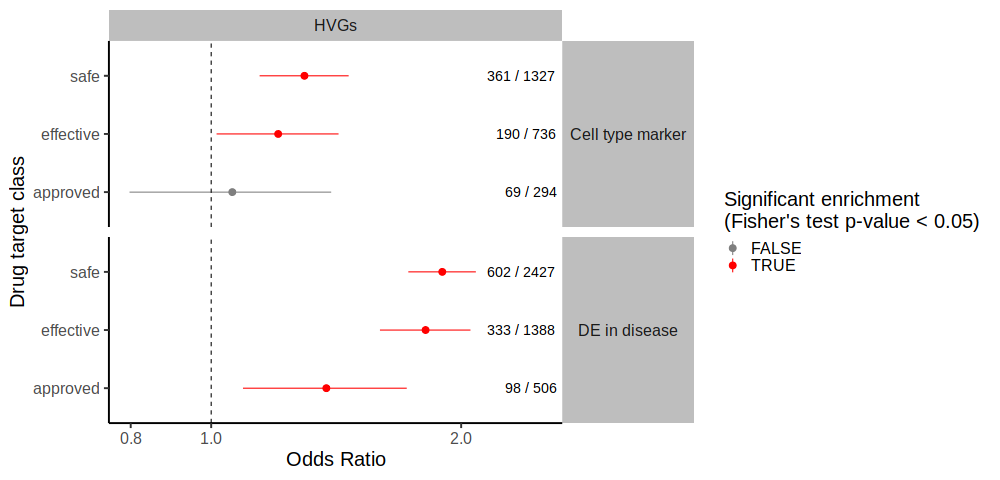

In [174]:
%%R -i hvgs_or_df -w 1000
plot_OR(hvgs_or_df, text_position='right') +
facet_grid(evidence~universe, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          )  +
expand_limits(x=2.5) +
ggsave_figdir('OR_HVGs', height=3, width=13)

## Plot intersection of universes

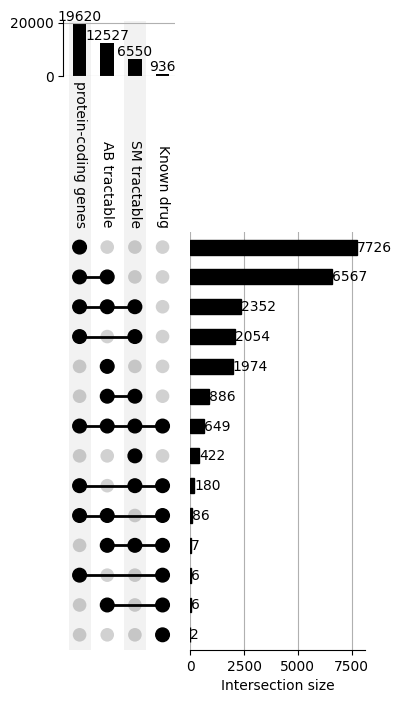

In [175]:
upset_dict = {'protein-coding genes':universe_dict['protein_coding_targets'],
    'SM tractable':universe_dict['sm_tractable_targets'],
    'AB tractable':universe_dict['ab_tractable_targets'],
     'Known drug':OT_targets_df[(OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & (OT_targets_df.known_drug > 0)].gene_id.unique().tolist()
#      'All OT targets': OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].gene_id.unique().tolist()
    }
# for k,v in annos_ensids.items():
#     upset_dict[k] = v
target_universe_upset = upsetplot.from_contents(upset_dict)

with plt.rc_context({'figure.figsize':[20,10]}):
    pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='vertical', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=28
    )
    pl.plot()
    plt.savefig(figdir + 'upset_gene_universe.png')
    plt.savefig(figdir + 'upset_gene_universe.pdf')

## Plot results

In [135]:
%%R -i results_all_df -w 2500 -h 500 -i figdir
pl_df <- 
    filter(results_all_df, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence'),
           universe %in% c('protein_coding_targets', 'sm_tractable_targets',
       'ab_tractable_targets','known_drug_targets')
          ) %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets',
       'ab_tractable_targets','known_drug_targets'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)'))

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

pl1 <- plot_OR(pl_df, text_position='right', evidence_levels=c('ct_marker_evidence', 'disease_evidence', 'all_sc_evidence', 'has_genetic_support')) +
    facet_grid(evidence~universe, scales='free_x',
               labeller = labeller(
                   evidence=as_labeller(evidence_labels),
                   universe=as_labeller(uni_labeller)
               )
              ) +
    expand_limits(x=60) +
    ggsave(paste0(figdir, 'OR_results_all.png'), height=7, width=20) +
    ggsave(paste0(figdir, 'OR_results_all.pdf'), height=7, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


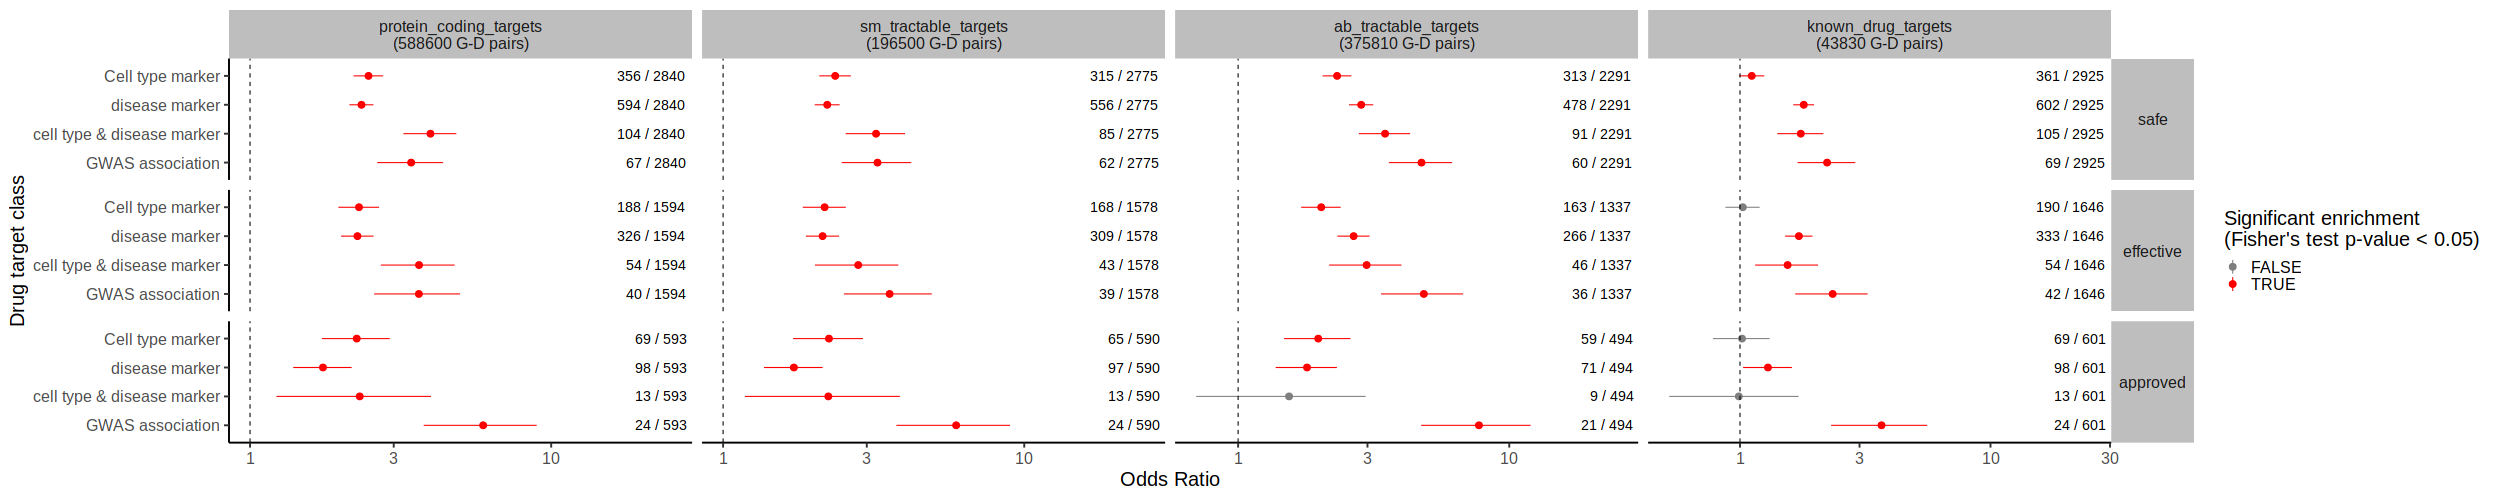

In [134]:
# %%R -i results_all_df -w 2500 -h 500 -i figdir
# pl_df <- 
#     filter(results_all_df, 
#                evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence'),
#            universe %in% c('protein_coding_targets', 'sm_tractable_targets',
#        'ab_tractable_targets','known_drug_targets')
#           ) %>%
#     mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets',
#        'ab_tractable_targets','known_drug_targets'))) %>%
#     mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)')) %>%
#     mutate(evidence = recode(evidence, !!!as.list(evidence_labels))) 
# #     mutate(evidence = factor(evidence, levels=c("Cell type marker", "disease marker", "cell type & disease\nmarker","GWAS association")))

# uni_labeller <- distinct(pl_df, universe, u_label) 
# uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

# plot_OR(pl_df, y_value='evidence',
#         text_position='right', 
#         evidence_levels=rev(c("Cell type marker", "disease marker", "cell type & disease marker","GWAS association")),
#         clinical_status_levels = c('druggable', 'safe', 'effective', 'approved')
#        ) +
#     facet_grid(clinical_status~universe, scales='free_x',
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
#                )
#               ) +
#     expand_limits(x=25) +
#     ggsave(paste0(figdir, 'OR_results_all_v2.png'), height=6, width=20) +
#     ggsave(paste0(figdir, 'OR_results_all_v2.pdf'), height=6, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


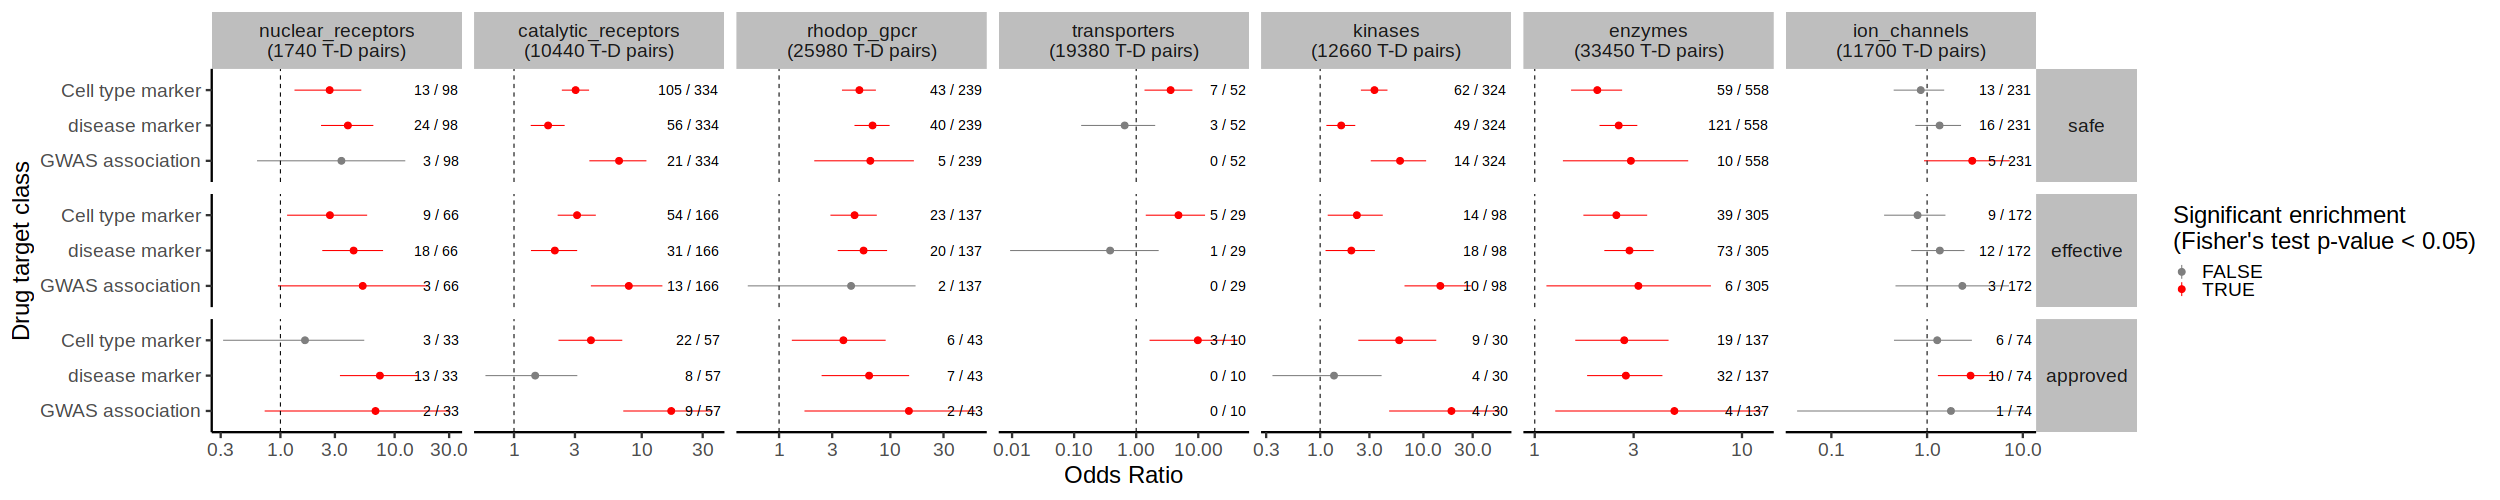

In [155]:
%%R -i results_all_df -w 2500 -h 500 -i figdir
pl_df <- 
    filter(results_all_df, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support'),
           universe %in% c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels')
          ) %>%
    mutate(universe = factor(universe, levels=c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' T-D pairs)')) %>%
        mutate(evidence = recode(evidence, !!!as.list(evidence_labels))) 

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

# plot_OR(pl_df, y_value='evidence',
#         text_position='right', 
#         evidence_levels=rev(c("Cell type marker", "disease marker", "GWAS association")),
#         clinical_status_levels = c('druggable', 'safe', 'effective', 'approved')
#        ) +
#     facet_grid(clinical_status~universe, scales='free_x',
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
#                )) +
#     expand_limits(x=25)
pl2 <- plot_OR(pl_df, 
               y_value='evidence',
        text_position='right', 
        evidence_levels=rev(c("Cell type marker", "disease marker", "GWAS association")),
        clinical_status_levels = c('druggable', 'safe', 'effective', 'approved'),
        base_font_size=24) +
    facet_grid(clinical_status~universe, scales='free_x',
               labeller = labeller(
                   universe=as_labeller(uni_labeller)
               )) 
pl2
# ggsave(paste0(figdir, 'OR_results_classes.png'), height=6, width=35) +
# ggsave(paste0(figdir, 'OR_results_classes.pdf'), height=6, width=35)

In [156]:
%%R -i results_all_df -w 2500 -h 500 -i figdir
pl_df <- 
    filter(results_all_df, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support'),
           universe %in% c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels')
          ) %>%
    mutate(universe = factor(universe, levels=c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)'))

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

pl2 <- plot_OR(pl_df, 
               text_position='right', 
               base_font_size=24,
               evidence_levels=c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support')) +
facet_grid(evidence~universe, scales='free_x',
           labeller = labeller(
               evidence=as_labeller(evidence_labels),
               universe=as_labeller(uni_labeller)
           )) +
ggsave(paste0(figdir, 'OR_results_classes.png'), height=6, width=35) +
ggsave(paste0(figdir, 'OR_results_classes.pdf'), height=6, width=35)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


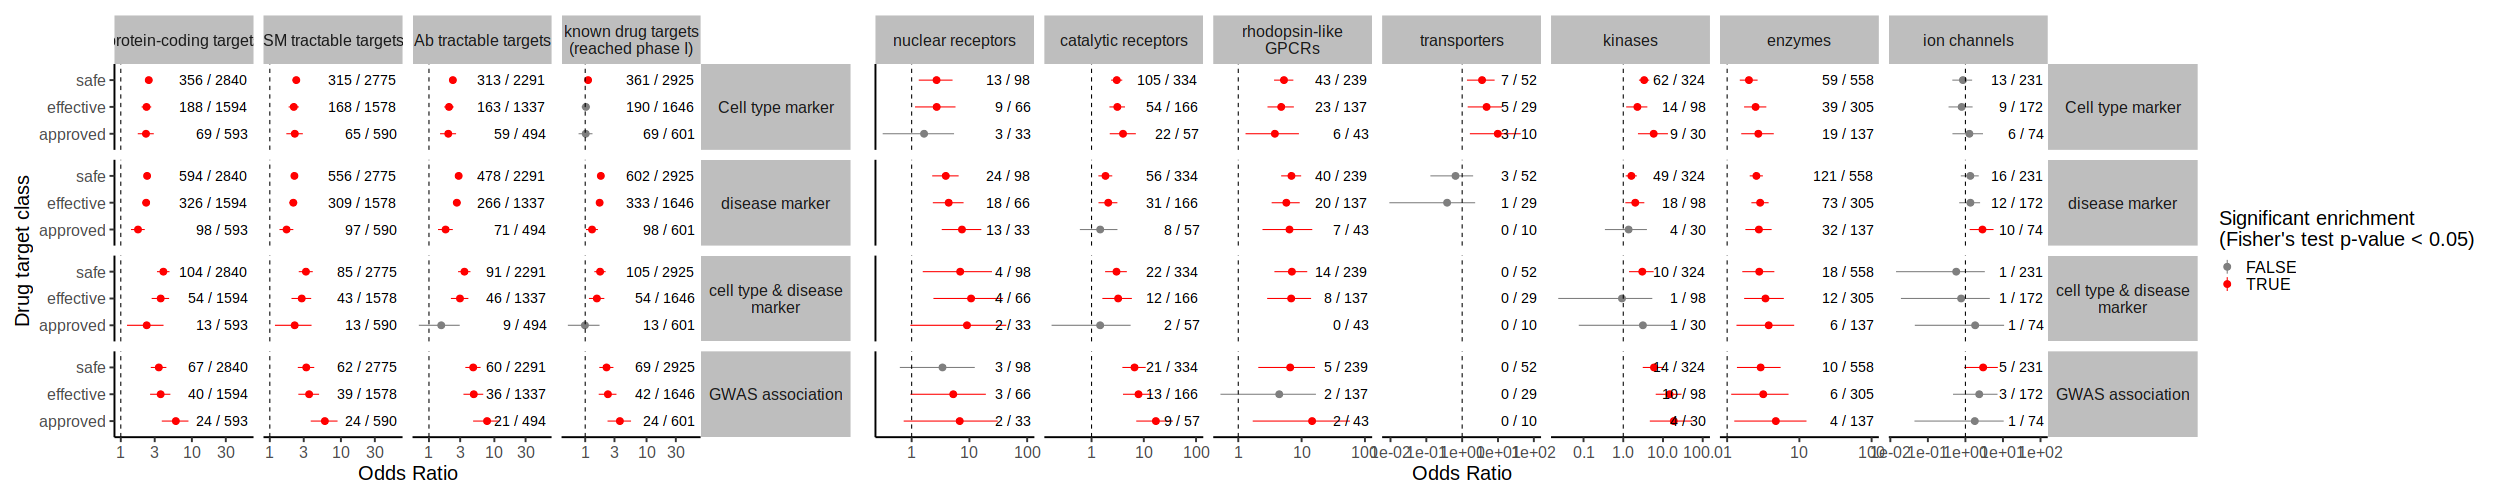

In [103]:
%%R -i results_all_df -w 2500 -h 500 
(pl1 + (pl2 + remove_y_axis())) + plot_layout(guides='collect', widths=c(1,2))

Check difference in evolutionary constraint on these classes of genes.

/tmp/ipykernel_230/2075788165.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  annos_table = gene_table[gene_table.GeneSymbol.isin(np.hstack(annos_ensids.values()))][['GeneSymbol', 'LOEUF', 'gene']]


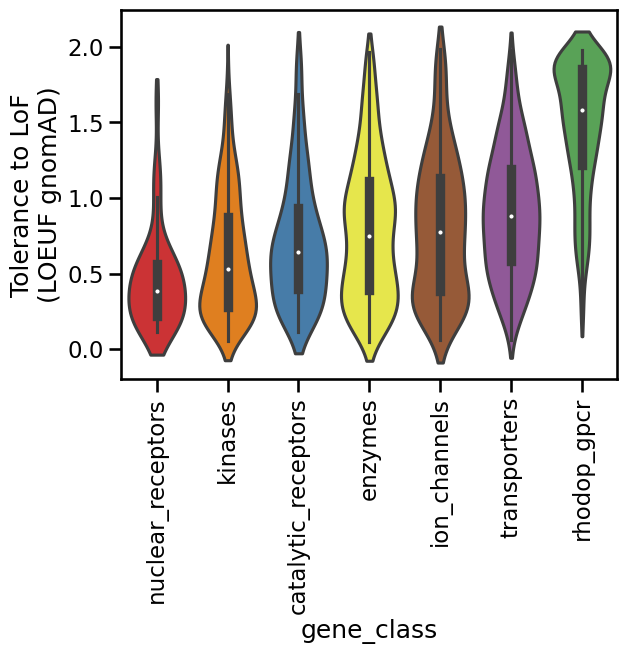

In [253]:
gene_table = pd.read_table("/home/jovyan/gene_annots/pc_genes.txt")

annos_df = pd.DataFrame([(k,x) for k,v in annos.items() for x in v])
annos_df.columns = ['gene_class', 'gene']
annos_table = gene_table[gene_table.GeneSymbol.isin(np.hstack(annos_ensids.values()))][['GeneSymbol', 'LOEUF', 'gene']]
annos_table = pd.merge(annos_table, annos_df)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk');
mean_pLI_order = annos_table.groupby('gene_class')['LOEUF'].mean().sort_values().index

sns.violinplot(data=annos_table, x='gene_class', y='LOEUF', scale='width', cut=True, order=mean_pLI_order, palette=gene_class_palette)
plt.ylabel('Tolerance to LoF\n(LOEUF gnomAD)')
plt.xticks(rotation=90)

# Show the plot
plt.show()


## Test combination of types of support

In [967]:
if targets_evidence_all.columns.str.contains("_AND_").any():
    targets_evidence_all.drop(targets_evidence_all.columns[targets_evidence_all.columns.str.contains("_AND_")], axis=1, inplace=True)
    targets_evidence_all.drop(targets_evidence_all.columns[targets_evidence_all.columns.str.contains("_OR_")], axis=1, inplace=True)

evidence_cols = ['has_genetic_support', 'ct_marker_evidence', 'disease_evidence']
for ev1 in evidence_cols:
    for ev2 in evidence_cols:
        targets_evidence_all[f'{ev1}_AND_{ev2}'] = ((targets_evidence_all[ev1] == 1) & (targets_evidence_all[ev2] == 1)).astype(int)
        targets_evidence_all[f'{ev1}_OR_{ev2}'] = ((targets_evidence_all[ev1] == 1) | (targets_evidence_all[ev2] == 1)).astype(int)

In [968]:
combo_evidence_cols = evidence_cols + [x for x in targets_evidence_all.columns if '_AND_' in x] + [x for x in targets_evidence_all.columns if '_OR_' in x]
results_combo_df = pd.DataFrame()

# Large universe
for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in combo_evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_combo_df = pd.concat([results_combo_df, or_df], axis=0)

# gene classes
for u_name, u_list in annos_ensids.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in combo_evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_combo_df = pd.concat([results_combo_df, or_df], axis=0)

In [972]:
results_combo_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe,ev1,ev2,operation
0,3.427745,2.643661,4.376804,7.886609e-17,2840.0,585760.0,67.0,4167.0,has_genetic_support,is_safe,protein_coding_targets,has_genetic_support,None,single
0,2.473965,2.206396,2.767363,3.574760e-46,2840.0,585760.0,356.0,32431.0,ct_marker_evidence,is_safe,protein_coding_targets,ct_marker_evidence,None,single
0,2.344857,2.137662,2.569004,4.434180e-64,2840.0,585760.0,594.0,59964.0,disease_evidence,is_safe,protein_coding_targets,disease_evidence,None,single
0,3.427745,2.643661,4.376804,7.886609e-17,2840.0,585760.0,67.0,4167.0,has_genetic_support_AND_has_genetic_support,is_safe,protein_coding_targets,has_genetic_support,has_genetic_support,AND
0,4.040363,1.611311,8.422065,2.197998e-03,2840.0,585760.0,7.0,365.0,has_genetic_support_AND_ct_marker_evidence,is_safe,protein_coding_targets,has_genetic_support,ct_marker_evidence,AND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.275862,0.450918,2.936741,3.465296e-01,74.0,11626.0,6.0,758.0,ct_marker_evidence_OR_ct_marker_evidence,is_approved,ion_channels,ct_marker_evidence,ct_marker_evidence,OR
0,2.072965,1.088803,3.714364,1.342828e-02,74.0,11626.0,15.0,1285.0,ct_marker_evidence_OR_disease_evidence,is_approved,ion_channels,ct_marker_evidence,disease_evidence,OR
0,2.788425,1.318745,5.366883,4.125203e-03,74.0,11626.0,11.0,696.0,disease_evidence_OR_has_genetic_support,is_approved,ion_channels,disease_evidence,has_genetic_support,OR
0,2.072965,1.088803,3.714364,1.342828e-02,74.0,11626.0,15.0,1285.0,disease_evidence_OR_ct_marker_evidence,is_approved,ion_channels,disease_evidence,ct_marker_evidence,OR


In [970]:
results_combo_df = pd.concat([results_combo_df, results_combo_df['evidence'].str.split("_AND_|_OR_", expand=True)], axis=1).rename({0:'ev1', 1:'ev2'}, axis=1)
results_combo_df['operation'] = np.where(results_combo_df.evidence.str.contains('AND'), 'AND', np.where(results_combo_df.evidence.str.contains('OR'), 'OR', 'single'))

In [990]:
results_combo_df = results_combo_df[results_combo_df['operation'] != 'single'].copy()

In [1044]:
%%R -i results_combo_df -i combo_evidence_cols -w 1500 -h 600
text_position = 'right'
pval_alpha = 0.05

pl_df <- results_combo_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=rev(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=combo_evidence_cols)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        mutate(ev2 = ifelse(is.na(ev2), ev1, ev2)) %>%
        mutate(ev2 = factor(ev2, levels=c(c('ct_marker_evidence', 'disease_evidence','has_genetic_support')))) %>%
        mutate(ev1 = factor(ev1, levels=c(c('ct_marker_evidence', 'disease_evidence','has_genetic_support')))) 
    
# Don't show values with no support
max_OR <- max((pl_df[,'ci_high']))

plot_combo <- function(univ){
    pl_ls <- lapply(c('AND', 'OR'), function(op){pl_df %>%
            filter(universe == univ & operation == op) %>%
            ggplot(aes(y=clinical_status, x=odds_ratio, color=is_signif)) +
            geom_point(
                data = . %>% filter(n_supported_approved > 0),
                size=3
            ) +
            geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                            aes(xmin=ci_low, xmax=ci_high)) +
            geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                      x = ifelse(text_position == 'right', Inf, -Inf) , 
                      hjust= ifelse(text_position == 'right', 1.1, -1) , 
                      size=5,
                      color='black',) +
            geom_vline(xintercept=1, linetype=2) +
            scale_x_log10() +
            xlab('Odds Ratio') +
            ylab('Drug target class') +
            theme_classic(base_size=20) +
            ggtitle(paste(univ, '-', op)) +
            scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                               name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
            facet_grid(ev1~ev2, labeller = labeller(ev1 = as_labeller(evidence_labels), ev2 = as_labeller(evidence_labels))) +
            theme(strip.text.y=element_text(angle=270), strip.background = element_rect(color=NA, fill = "grey")) 
        })

    wrap_plots(pl_ls) + plot_layout(guides='collect')
    
}

for (univ in unique(pl_df$universe)){ 
    plot_combo(univ) 
    ggsave_figdir(paste0('OR_combo_', univ), width=26, height=7)}


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### Overlap between evidence sets

In [101]:
def _get_frac_supported(drug_target_evidence, ev_col, success_col):
    n_supported = sum((drug_target_evidence[ev_col]==1) & (drug_target_evidence[success_col]==1))
    n_total = sum(drug_target_evidence[success_col]==1)
    print(f'{success_col} - supported by {ev_col} {(np.round(n_supported/n_total, 5)) * 100}% ({n_supported} / {n_total})')

drug_target_evidence = targets_evidence_all[targets_evidence_all['is_druggable'] == 1]
drug_target_evidence['any_sc_evidence'] = ((drug_target_evidence['disease_evidence'] == 1) | (drug_target_evidence['ct_marker_evidence'] == 1)).astype(int)

print("--- Genetic support ---")
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_safe')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_effective')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_approved')
print("--- scRNA-seq support ---")
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_approved')


--- Genetic support ---
is_druggable - supported by has_genetic_support 2.186% (77 / 3522)
is_safe - supported by has_genetic_support 2.359% (69 / 2925)
is_effective - supported by has_genetic_support 2.552% (42 / 1646)
is_approved - supported by has_genetic_support 3.993% (24 / 601)
--- scRNA-seq support ---
is_druggable - supported by any_sc_evidence 28.535% (1005 / 3522)
is_safe - supported by any_sc_evidence 29.333% (858 / 2925)
is_effective - supported by any_sc_evidence 28.493000000000002% (469 / 1646)
is_approved - supported by any_sc_evidence 25.624000000000002% (154 / 601)
is_druggable - supported by all_sc_evidence 3.6630000000000003% (129 / 3522)
is_safe - supported by all_sc_evidence 3.5900000000000003% (105 / 2925)
is_effective - supported by all_sc_evidence 3.2809999999999997% (54 / 1646)
is_approved - supported by all_sc_evidence 2.163% (13 / 601)
is_safe - supported by ct_marker_evidence 12.342% (361 / 2925)
is_effective - supported by ct_marker_evidence 11.543000000000

/tmp/ipykernel_230/3148567296.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_target_evidence['any_sc_evidence'] = ((drug_target_evidence['disease_evidence'] == 1) | (drug_target_evidence['ct_marker_evidence'] == 1)).astype(int)


In [ ]:
_get_frac_supported(drug_target_evidence[drug_target_evidence.], 'all_sc_evidence', 'is_safe')

In [1064]:
targets_evidence_all['target_disease'] = targets_evidence_all['gene_id'] + "_" + targets_evidence_all['disease_ontology_id']
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']

for col in ['is_safe', 'is_effective', 'is_approved']:
    evidence_sets_dict = {}
    for ev in evidence_cols:
        evidence_sets_dict[ev] = targets_evidence_all.target_disease[
            (targets_evidence_all[ev] == 1)
            & (targets_evidence_all[col] == 1)
        ].tolist()

    evidence_upset = upsetplot.from_contents(evidence_sets_dict)

    pl = upsetplot.UpSet(
        evidence_upset, 
        orientation='horizontal', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        intersection_plot_elements=3
    )

    pl.plot()
    plt.savefig(figdir + f'upset_evidence_{col}.pdf')
    plt.savefig(figdir + f'upset_evidence_{col}.png')

In [27]:
targets_evidence_all[(targets_evidence_all['has_genetic_support'] == 1) & (targets_evidence_all.ct_marker_evidence==1) & (targets_evidence_all.is_safe==1)]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,...,gene_name,is_nuclear_receptors,is_catalytic_receptors,is_rhodop_gpcr,is_transporters,is_kinases,is_enzymes,is_ion_channels,gene_class,all_sc_evidence
58067,58067,58067,58067,ENSG00000232810,MONDO_0005011,0.068668,0.990551,1.0,1.0,1.0,...,TNF,0,0,0,0,0,0,0,other,0
262533,262533,262533,262533,ENSG00000066468,MONDO_0007254,0.637954,0.189174,1.0,1.0,0.0,...,FGFR2,0,1,0,0,1,0,0,catalytic_receptors,0
362102,362102,362102,362102,ENSG00000151617,MONDO_0005002,0.529119,0.121586,1.0,1.0,0.0,...,EDNRA,0,0,1,0,0,0,0,rhodop_gpcr,0
391298,391298,391298,391298,ENSG00000072694,MONDO_0007915,0.511125,0.121586,1.0,1.0,0.0,...,FCGR2B,0,0,0,0,0,0,0,other,0
391343,391343,391343,391343,ENSG00000101017,MONDO_0007915,0.374120,0.121586,1.0,1.0,0.0,...,CD40,0,1,0,0,0,0,0,catalytic_receptors,0
391474,391474,391474,391474,ENSG00000121594,MONDO_0007915,0.558075,0.169292,1.0,1.0,0.0,...,CD80,0,0,0,0,0,0,0,other,0
391916,391916,391916,391916,ENSG00000196664,MONDO_0007915,0.786693,0.844516,1.0,1.0,1.0,...,TLR7,0,1,0,0,0,0,0,catalytic_receptors,0


## Compare types of disease markers

Up vs down-regulation, tissue-level vs cell type level 

In [20]:
def _parse_DE_in_disease(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    lfc_thresh=0.5,
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    lfc_thresh
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = {}
    for gr in ['positive', 'negative']:
        disease_evidence = sc_evidence_utils.DE2evidence_disease(
            disease_res, bulk_res,  signif_thresh=signif_thresh, lfc_thresh=lfc_thresh, lfc_group=gr)
        for k in disease_evidence.keys():
            disease_evidence[f'{k}_{gr}'] = disease_evidence.pop(k)
        evidence_dict.update(disease_evidence)

    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [21]:
targets_evidence_disease = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE_in_disease(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            lfc_thresh = 0.5
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_disease = pd.concat([targets_evidence_disease, targets_disease_df], axis=0)


missing MONDO_0024661
missing MONDO_0001627
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0018874
missing MONDO_0012883
missing MONDO_0024660
missing MONDO_0005115
missing MONDO_0005575
missing MONDO_0016691
missing MONDO_0018177
missing MONDO_0024885


In [23]:
# targets_evidence_disease = pd.merge(targets_evidence_disease, ens_ids_to_name, how='left')
# for k,a in annos.items():
#     targets_evidence_disease[f'is_{k}'] = targets_evidence_disease.gene_name.isin(a).astype('int')

# gene_group_cols = [f'is_{k}' for k in annos.keys()]
# targets_evidence_disease['gene_class'] = np.where(
#     targets_evidence_disease[gene_group_cols].sum(1) > 0,
#     targets_evidence_disease[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
#     'other'
#         )

In [24]:
targets_evidence_disease

,genetic_association,known_drug,is_druggable,is_safe,is_effective,is_approved,has_genetic_support,gene_id,disease_ontology_id,bulk_disease_evidence_positive,disease_evidence_positive,disease_ct_evidence_positive,bulk_disease_evidence_negative,disease_evidence_negative,disease_ct_evidence_negative,disease,disease_relevant_tissue
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000000938,MONDO_0000709,0.0,1.0,1.0,0.0,1.0,1.0,Crohn ileitis,small intestine
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000000971,MONDO_0000709,0.0,1.0,1.0,0.0,0.0,0.0,Crohn ileitis,small intestine
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000001626,MONDO_0000709,0.0,0.0,0.0,1.0,1.0,0.0,Crohn ileitis,small intestine
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000001630,MONDO_0000709,0.0,0.0,0.0,1.0,1.0,0.0,Crohn ileitis,small intestine
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000002330,MONDO_0000709,0.0,0.0,0.0,0.0,1.0,1.0,Crohn ileitis,small intestine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000288558,MONDO_0007915,0.0,0.0,0.0,1.0,1.0,0.0,systemic lupus erythematosus,blood
7891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000288649,MONDO_0007915,0.0,0.0,0.0,1.0,1.0,0.0,systemic lupus erythematosus,blood
7892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000288675,MONDO_0007915,0.0,0.0,0.0,1.0,1.0,0.0,systemic lupus erythematosus,blood
7893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSG00000288701,MONDO_0007915,0.0,0.0,0.0,1.0,1.0,0.0,systemic lupus erythematosus,blood


In [25]:
evidence_cols = ['bulk_disease_evidence_positive',
       'disease_evidence_positive', 'disease_ct_evidence_positive',
       'bulk_disease_evidence_negative', 'disease_evidence_negative',
       'disease_ct_evidence_negative']

In [26]:
results_disease_df = pd.DataFrame()
for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_disease, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

results_disease_df['DE_sign'] = [x[-1] for x in results_disease_df['evidence'].str.split('_')]
# results_disease_df['evidence'] = results_disease_df['evidence'].str.replace("_positive", '').str.replace("_negative", '')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


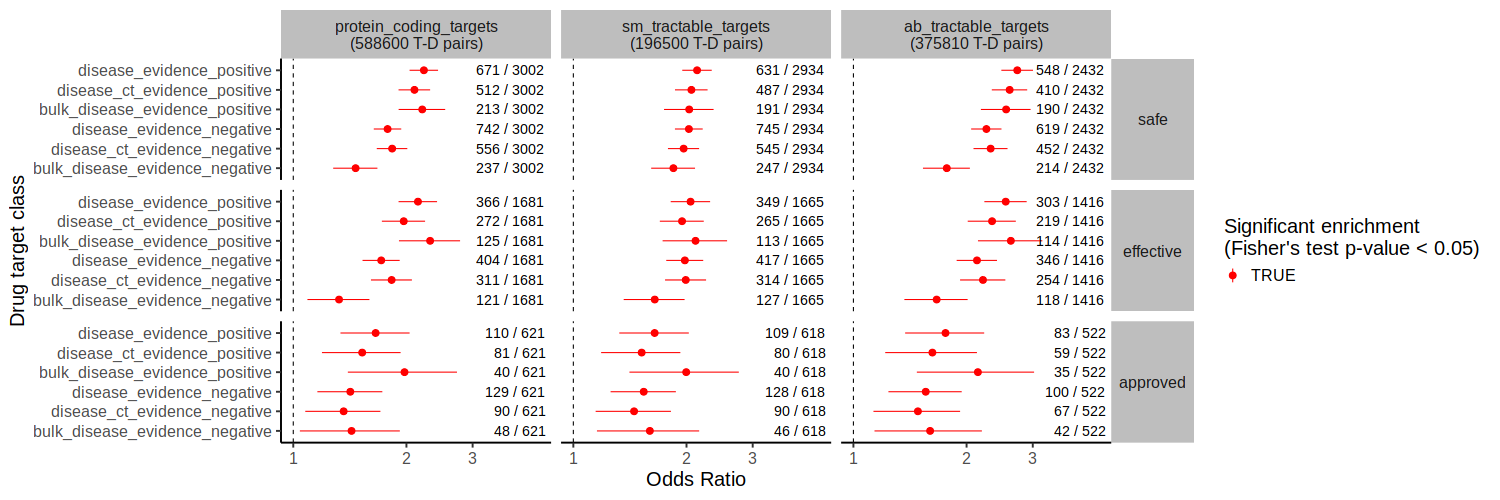

In [27]:
%%R -i results_disease_df -w 1500 -h 500
pl_df <- results_disease_df %>%
     mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' T-D pairs)')) 
#     filter(clinical_status=='is_safe')

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

plot_OR(pl_df, text_position='right', y_value='evidence',
        evidence_levels=c(
            'bulk_disease_evidence_negative', 'disease_ct_evidence_negative', 'disease_evidence_negative',
            'bulk_disease_evidence_positive', 'disease_ct_evidence_positive', 'disease_evidence_positive'
        )) +
facet_grid(factor(clinical_status, levels=c('safe','effective', 'approved')) ~ universe, scales='free_x',
           labeller = labeller(
#                evidence=as_labeller(evidence_labels),
               universe=as_labeller(uni_labeller)
           )
          ) +
expand_limits(x=4.5) +
ggsave(paste0(figdir, 'OR_disease_evidence.png'), height=7, width=20) +
ggsave(paste0(figdir, 'OR_disease_evidence.pdf'), height=7, width=20)

## Stratified OR by disease

In [81]:
evidence_cols =  [ 'ct_marker_evidence', 'disease_evidence', 'has_genetic_support']

n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
test_diseases = n_x_disease.index[(n_x_disease['has_genetic_support'] > 0) & (n_x_disease['is_approved'] > 0)]
OR_disease_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all['disease_ontology_id'].isin(test_diseases)], 
    group_by = 'disease_ontology_id', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

OR_disease_df['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]
OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]

disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

/tmp/ipykernel_225/1131277745.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()


In [83]:
OR_disease_df.to_csv('../data/suppl_table_odds_ratios.disease.csv')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


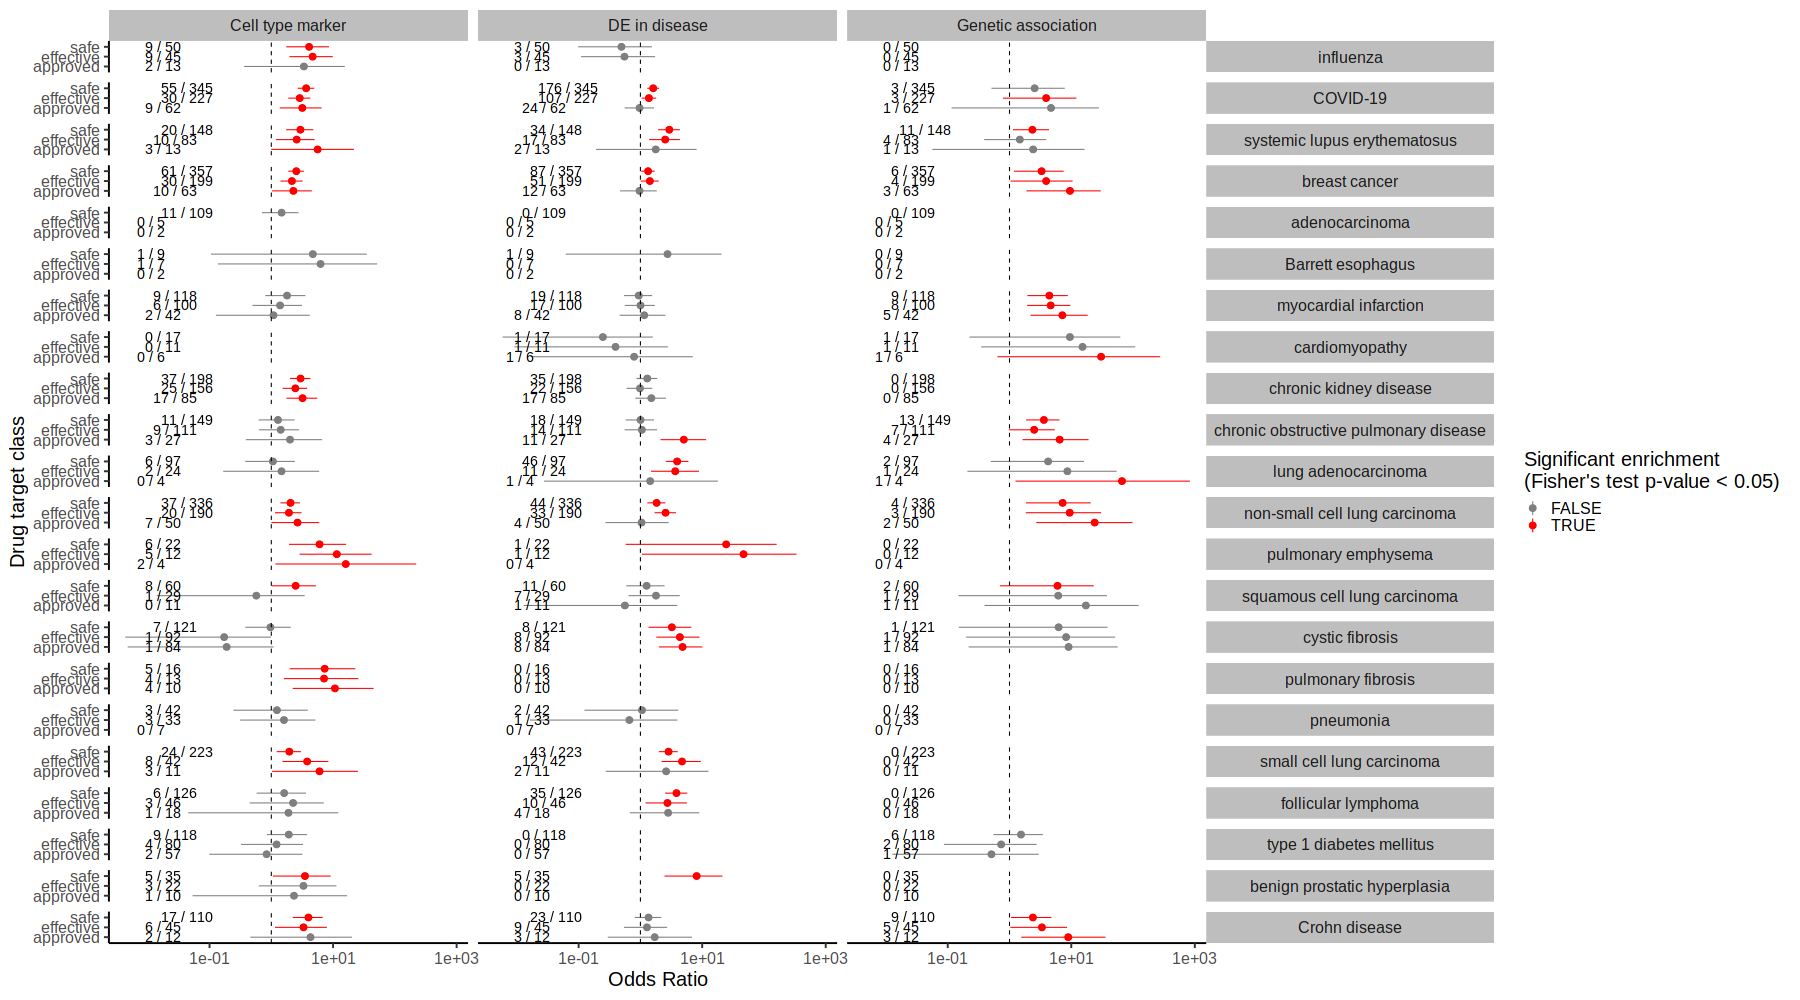

In [832]:
%%R -i OR_disease_df -h 1000 -w 1800 -i disease_order

OR_disease_df <- mutate(OR_disease_df, disease = factor(disease, levels=as.list(disease_order))) %>%
    filter(evidence %in% c('ct_marker_evidence', 'disease_evidence','has_genetic_support'))

plot_OR(OR_disease_df, 
        text_position='left') +
    facet_grid(disease~evidence, 
               labeller = labeller(evidence = as_labeller(evidence_labels))) +
    expand_limits(x=0.05) +
    ggsave(paste0(figdir, 'OR_results.by_disease.png'), height=18, width=20) +
    ggsave(paste0(figdir, 'OR_results.by_disease.pdf'), height=18, width=20)

In [829]:
n_x_tissue = targets_evidence_all.groupby('disease_relevant_tissue').sum()
test_tissues = n_x_tissue.index[(n_x_tissue['disease_ct_evidence'] > 0) & (n_x_tissue['is_approved'] > 0)]

OR_tissue_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all.disease_relevant_tissue.isin(test_tissues)], 
    group_by = 'disease_relevant_tissue', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

/tmp/ipykernel_2097/694968752.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_tissue = targets_evidence_all.groupby('disease_relevant_tissue').sum()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


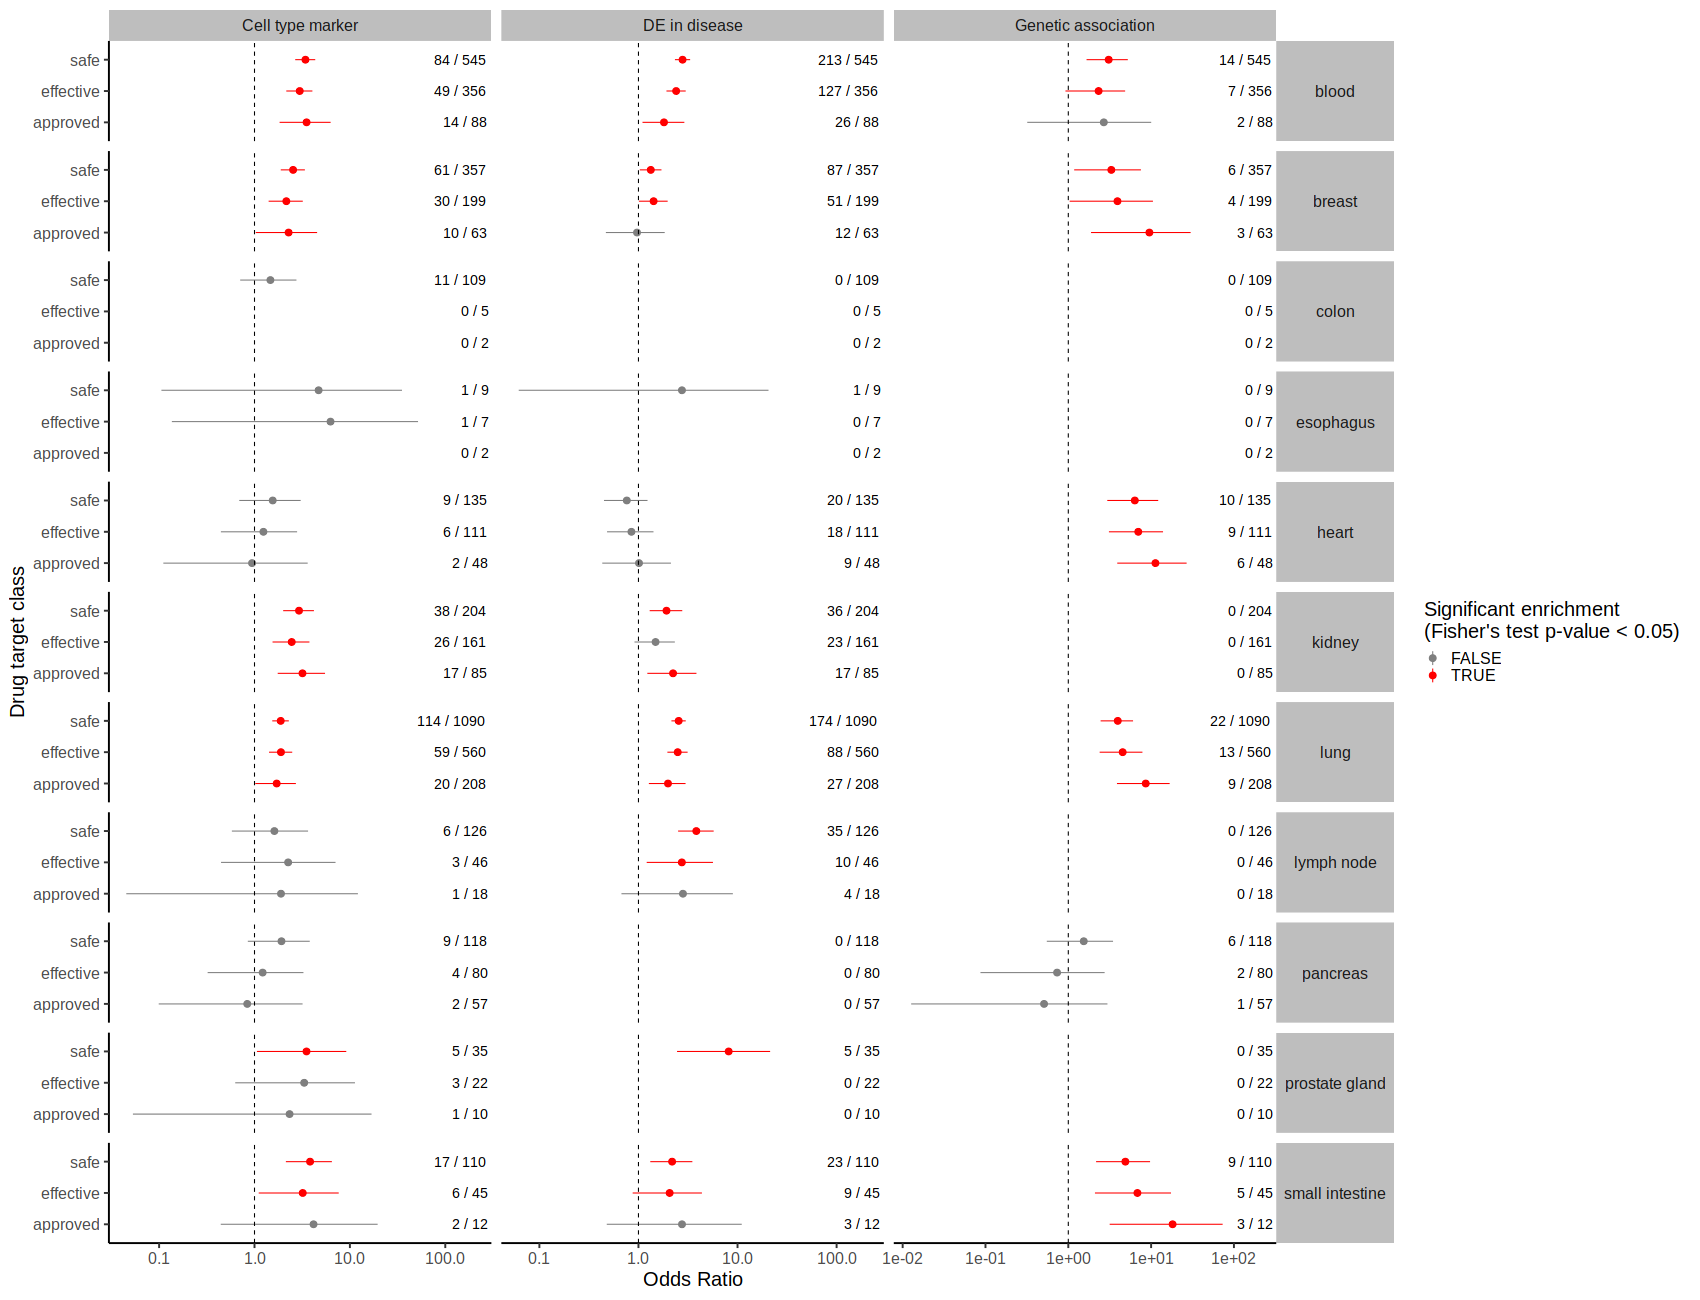

In [830]:
%%R -i OR_tissue_df -h 1300 -w 1700 

plot_OR(OR_tissue_df,  text_position='right') +
    facet_grid(disease_relevant_tissue~evidence, 
               labeller = labeller(evidence = as_labeller(evidence_labels)),
               scales='free_x'
              ) +
    expand_limits(x=200) +
    ggsave(paste0(figdir, 'OR_results.by_tissue.png'), height=18, width=25)

## Test dependency on lfc and fraction of cell type in marker genes

In [839]:
targets_evidence_all_lfc = pd.DataFrame()
for min_lfc in [0.1, 1, 2, 3, 4, 5,6,7]:
    for disease_ontology_id in all_disease_ids:
        try:
            targets_disease_df = _parse_DE(
                disease_ontology_id, OT_targets_df,
                signif_thresh = 0.01,
                DE2evidence_celltype_params = {"lfc_thresh":min_lfc, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":min_lfc, 'lfc_group':'positive'},
            )
        except FileNotFoundError:
            continue
        targets_disease_df['min_lfc'] = min_lfc
        targets_evidence_all_lfc = pd.concat([targets_evidence_all_lfc, targets_disease_df], axis=0)

In [840]:
targets_evidence_all_lfc.to_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

In [841]:
targets_evidence_all_lfc = pd.read_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

Association statistics

In [842]:
lfc_OR_all = pd.DataFrame()

for u in universe_dict.keys():
    lfc_OR = association_utils.compute_grouped_OR(
        targets_evidence_all_lfc, 
        group_by = 'min_lfc', 
        evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence'],
        clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
        gene_universe = universe_dict[u]
        )
    lfc_OR['universe'] = u
    lfc_OR_all = pd.concat([lfc_OR_all, lfc_OR])
   

In [843]:
 # Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all_lfc.disease_ontology_id.unique())].copy()

# Merge with sc evidence (keeping just OT targets)
OT_targets_lfc_df = pd.DataFrame()
for fc in targets_evidence_all_lfc.min_lfc.unique():
    df = pd.merge(OT_targets_test_df, targets_evidence_all_lfc[targets_evidence_all_lfc.min_lfc == fc], how='left').fillna(0)
    df['min_lfc'] = fc
    OT_targets_lfc_df = pd.concat([OT_targets_lfc_df, df])
    
lfc_OR = association_utils.compute_grouped_OR(
        OT_targets_lfc_df, 
        group_by = 'min_lfc', 
        evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence'],
        clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
        )
lfc_OR['universe'] = 'OT_targets'
lfc_OR_all = pd.concat([lfc_OR_all, lfc_OR])

In [844]:
%%R
plot_OR_lfc <- function(
    results_all_df, 
    pval_alpha=0.05, 
    text_position='right',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'any')){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        mutate(min_lfc = factor(min_lfc, levels=rev(unique(min_lfc))))
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=min_lfc, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Min. logFC') +
#         coord_flip() +
        theme_classic(base_size=20) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


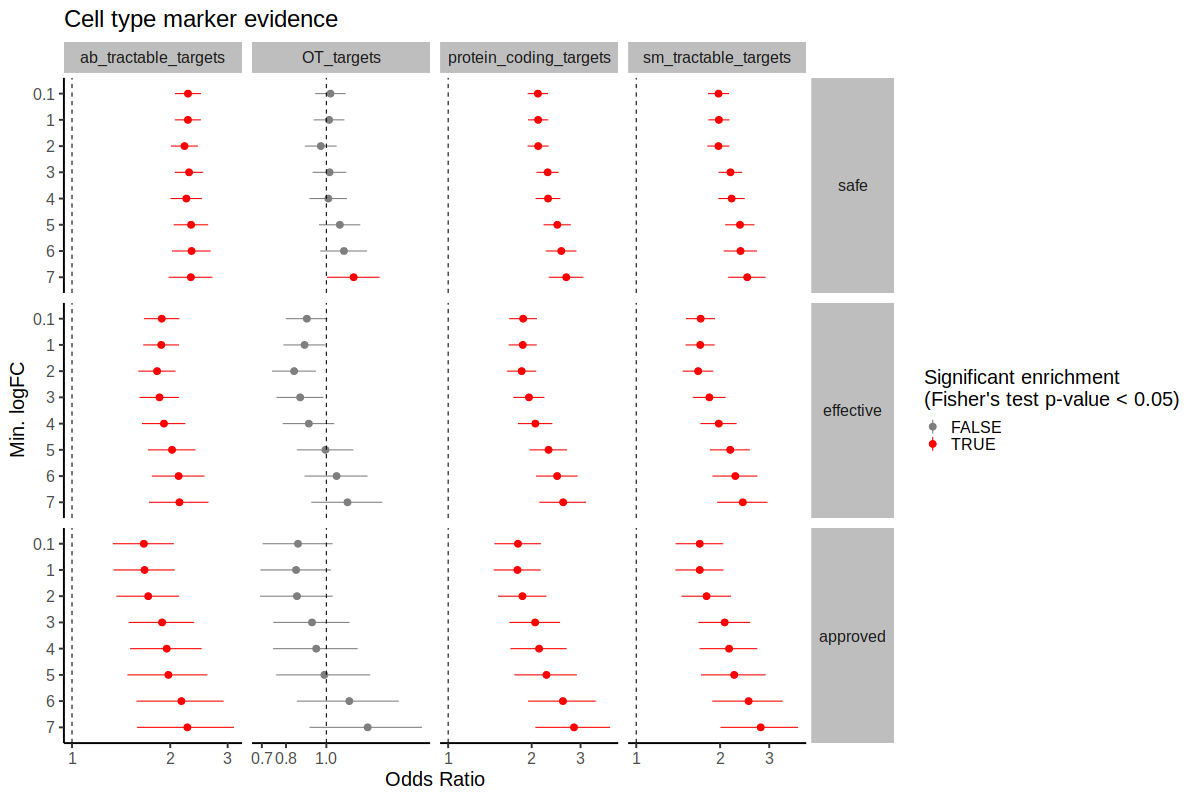

In [845]:
%%R -i lfc_OR_all -w 1200 -h 800
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'ct_marker_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('Cell type marker evidence') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_marker_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_marker_evidence.pdf'), height=8, width=15)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


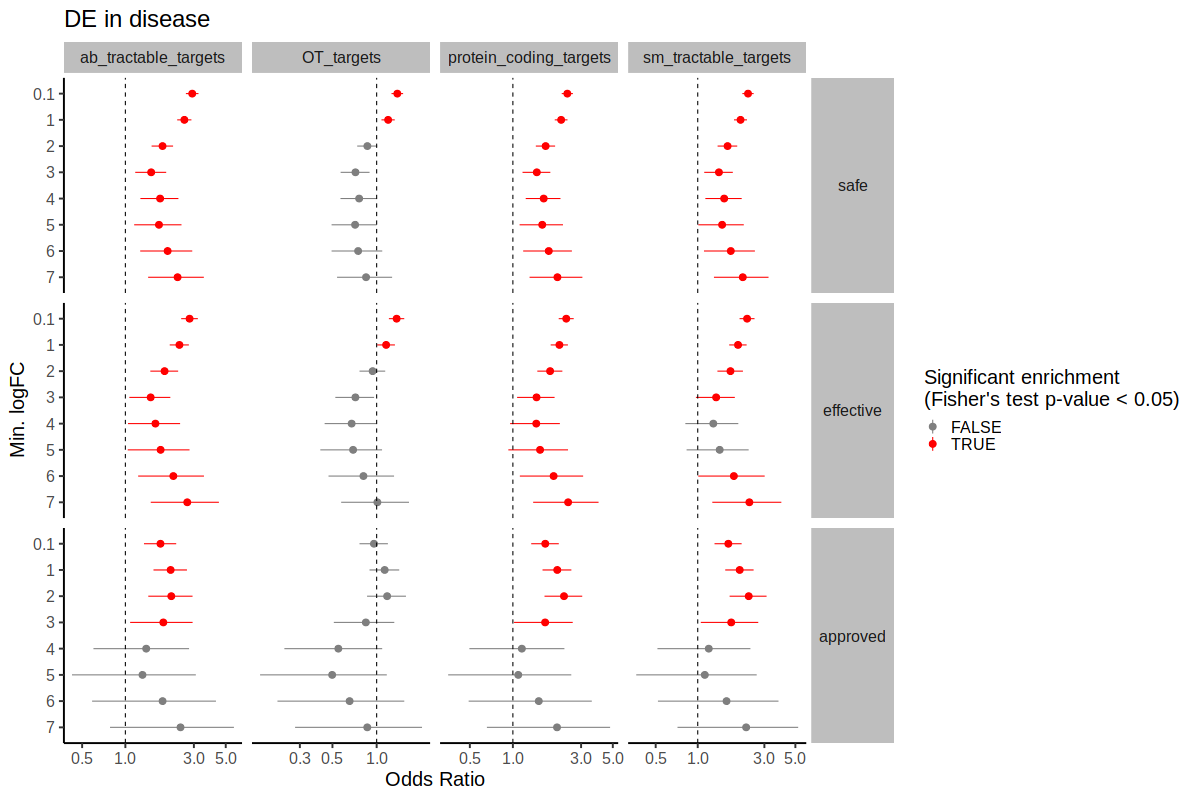

In [846]:
%%R -i lfc_OR_all -w 1200 -h 800
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'disease_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('DE in disease') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_evidence.pdf'), height=8, width=15)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


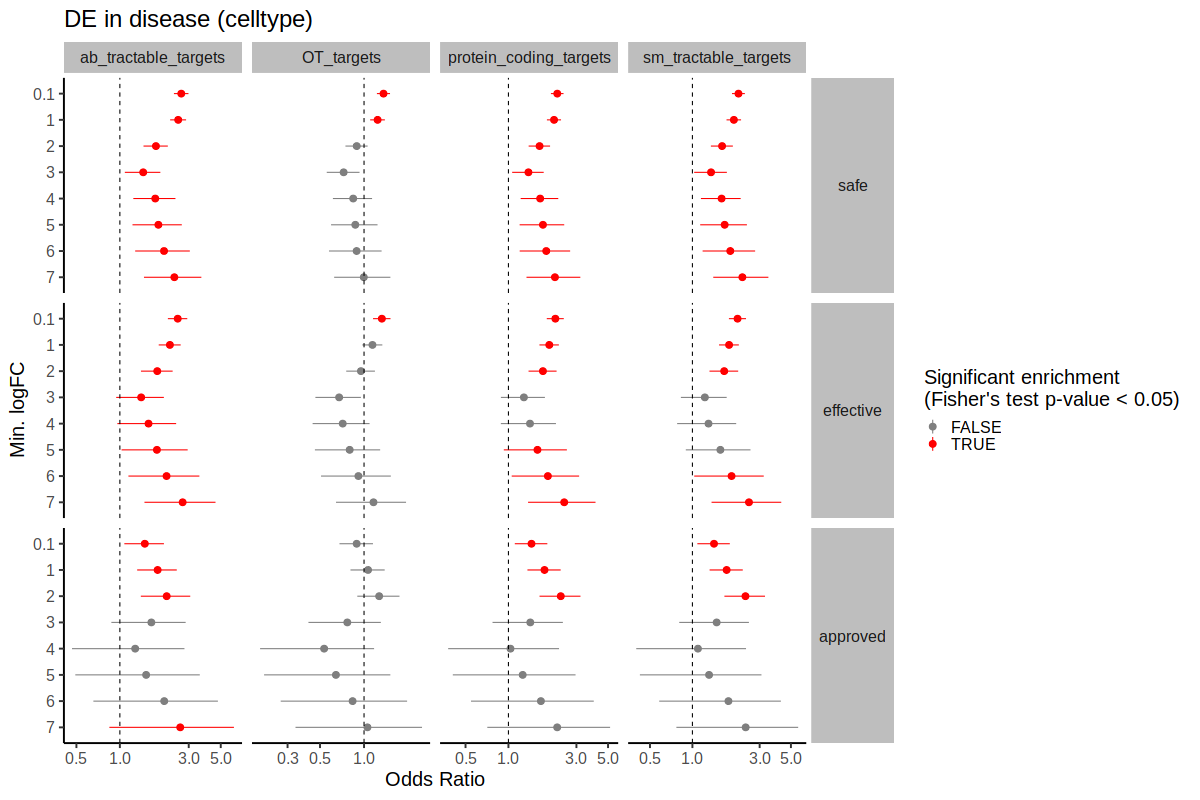

In [847]:
%%R -i lfc_OR_all -w 1200 -h 800  
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'disease_ct_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('DE in disease (celltype)') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_ct_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_ct_evidence.pdf'), height=8, width=15)

In [848]:
pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()

/tmp/ipykernel_2097/112256373.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


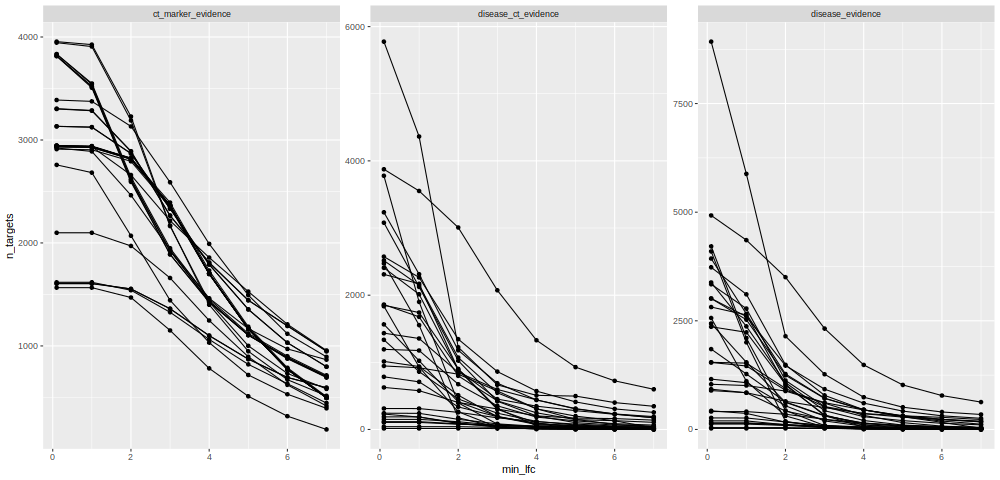

In [849]:
%%R -i pl_df -w 1000
pl_df %>%
pivot_longer(cols = c(ct_marker_evidence, disease_evidence, disease_ct_evidence), values_to='n_targets', names_to='sc_evidence') %>%
ggplot(aes(min_lfc, n_targets)) +
geom_point() +
geom_line(aes(group=disease_ontology_id)) +
facet_wrap(sc_evidence~., scales='free')

### More diagnostic plots for DE results

For both:
- Number of tested celltypes vs number of targets with evidence (for both)

For celltype markers:
- Check overlap in ct_marker targets between cell types present across tissues: jaccard index for marker evidence genes for each cell type across tissues --> do we cluster by cell type or tissue? or, check mean JI of matched cell type vs other cell types

For disease markers:
- How does the overlap btw disease-specific and bulk genes change with logFC? 


In [630]:
# Get number of tested targets x disease
def _ncelltypes_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    return(ct_res['high_level_cell_type_ontology_term_id'].nunique(), disease_res['high_level_cell_type_ontology_term_id'].nunique())

In [631]:
targets_evidence_all['n_cts_markers'] = np.nan
targets_evidence_all['n_cts_disease'] = np.nan

for disease_ontology_id in all_disease_ids:
    try:
        n_cts_markers, n_cts_disease = _ncelltypes_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_markers'] = n_cts_markers
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_disease'] = n_cts_disease
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue

missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0018874
missing MONDO_0001056
missing MONDO_0024885
missing MONDO_0024660


In [632]:
n_targets_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()
n_targets_by_disease = pd.merge(n_targets_by_disease, targets_evidence_all[['n_cts_markers', 'n_cts_disease', 'disease_ontology_id']].drop_duplicates())

/tmp/ipykernel_2097/1027269127.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_targets_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()


In [633]:
n_targets_by_disease['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace("_", ":")] for x in n_targets_by_disease.disease_ontology_id]

In [634]:
%%R -i n_targets_by_disease -w 1000 -h 500
pl1 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_markers, ct_marker_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ggpubr::stat_cor(size=7) +
    ylab('# celltype marker targets') +
    xlab('# tested celltypes') 


pl2 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_disease, disease_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ylab('# DE in disease targets') +
    xlab('# tested celltypes') +
    ggpubr::stat_cor(size=7, aes(n_cts_disease, disease_evidence), inherit.aes = FALSE)

pl3 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_disease, disease_ct_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ylab('# DE in disease (cell type) targets') +
    xlab('# tested celltypes') +
    ggpubr::stat_cor(size=7, aes(n_cts_disease, disease_ct_evidence), inherit.aes = FALSE)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


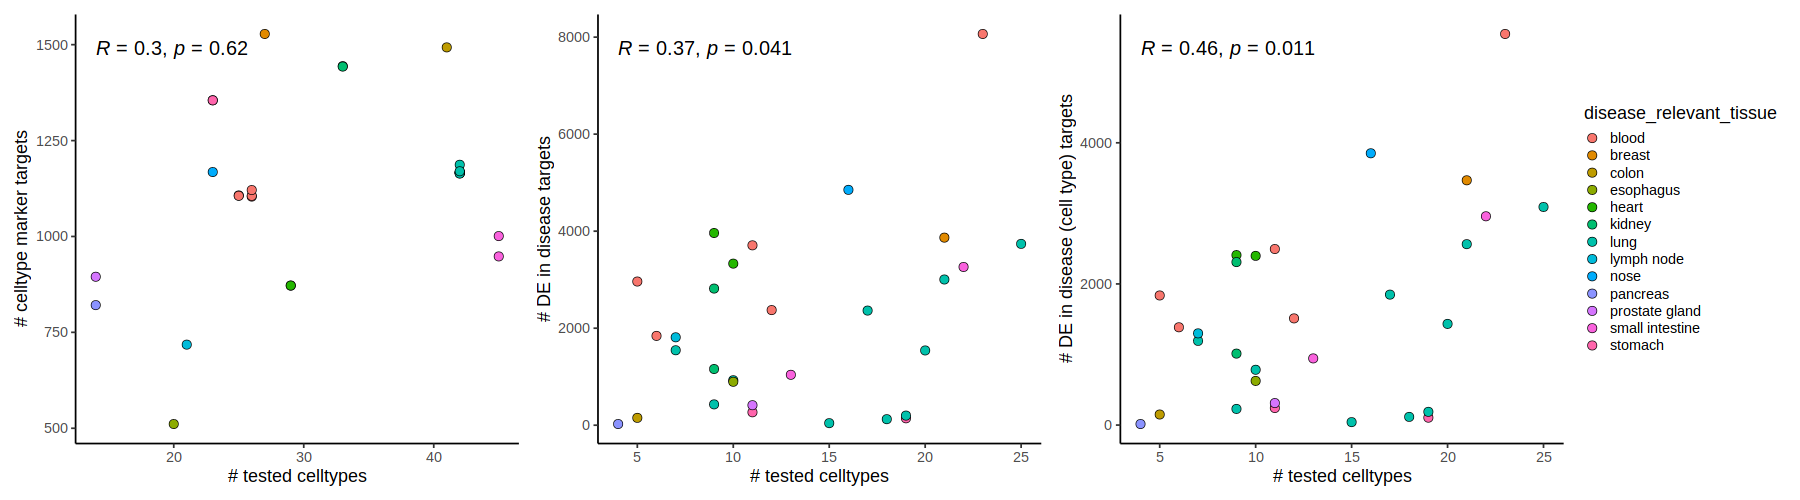

In [635]:
%%R -i n_targets_by_disease -w 1800 -h 500
(pl1 | pl2 | pl3) + plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.png'), height=5, width=18) +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.pdf'), height=5, width=18) 

In [636]:
pl_df = pd.merge(OR_disease_df, n_targets_by_disease[['n_cts_markers', 'n_cts_disease', 'disease_ontology_id']])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


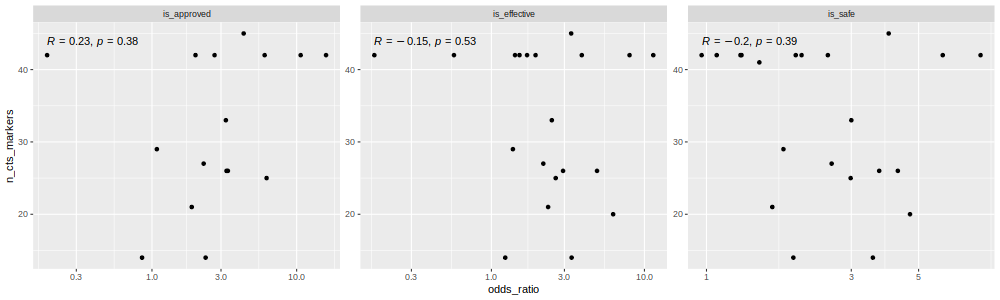

In [637]:
%%R -i pl_df -w 1000 -h 300
pl_df %>%
filter(evidence == 'ct_marker_evidence') %>%
ggplot(aes(odds_ratio, n_cts_markers)) +
geom_point(data = . %>% filter(n_supported_approved > 0)) +
# geom_pointrange(data = . %>% filter(n_supported_approved > 0),
#                         aes(xmin=ci_low, xmax=ci_high)) +
scale_x_log10() +
ggpubr::stat_cor() +
facet_wrap(clinical_status~., scales='free')

### Analysis by target class

In [850]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['TARBP1', 'SMG6', 'P2RX5', ..., 'GPR25', 'C3AR1', 'PPIA'],
      dtype=object)

In [639]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv')
targets_evidence_all = pd.merge(targets_evidence_all, ens_ids_to_name, how='left')
for k,a in annos.items():
    targets_evidence_all[f'is_{k}'] = targets_evidence_all.gene_name.isin(a).astype('int')

gene_group_cols = [f'is_{k}' for k in annos.keys()]
targets_evidence_all['gene_class'] = np.where(
    targets_evidence_all[gene_group_cols].sum(1) > 0,
    targets_evidence_all[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )
    

In [640]:
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

In [642]:
res_gr = pd.DataFrame()
for g in gene_group_cols:
    gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all.is_druggable == 1], evidence_col='ct_marker_evidence', clinical_status_col=g)
    res_gr = pd.concat([res_gr, gr_df])
#     gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all.is_druggable == 1], evidence_col='all_sc_evidence', clinical_status_col=g)
#     res_gr = pd.concat([res_gr, gr_df])
    gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all.is_druggable == 1], evidence_col='disease_evidence', clinical_status_col=g)
    res_gr = pd.concat([res_gr, gr_df])
    gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all.is_druggable == 1], evidence_col='has_genetic_support', clinical_status_col=g)
    res_gr = pd.concat([res_gr, gr_df])

In [502]:
res_gr

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status
0,0.984947,0.514787,1.751569,5.649305e-01,113.0,3409.0,14.0,442.0,ct_marker_evidence,is_nuclear_receptors
0,1.655981,1.117645,2.457872,5.560375e-03,113.0,3409.0,59.0,1414.0,disease_evidence,is_nuclear_receptors
0,1.229036,0.244029,3.830222,4.518352e-01,113.0,3409.0,3.0,77.0,has_genetic_support,is_nuclear_receptors
0,3.626622,2.812889,4.659440,2.473633e-22,395.0,3127.0,117.0,442.0,ct_marker_evidence,is_catalytic_receptors
0,1.543500,1.244079,1.914916,3.299886e-05,395.0,3127.0,196.0,1414.0,disease_evidence,is_catalytic_receptors
0,3.516541,2.034753,5.907005,5.709043e-06,395.0,3127.0,23.0,77.0,has_genetic_support,is_catalytic_receptors
0,1.656810,1.183370,2.287254,1.696241e-03,287.0,3235.0,53.0,442.0,ct_marker_evidence,is_rhodop_gpcr
0,0.756166,0.580314,0.980529,9.875588e-01,287.0,3235.0,98.0,1414.0,disease_evidence,is_rhodop_gpcr
0,0.778961,0.243520,1.926041,7.647515e-01,287.0,3235.0,5.0,77.0,has_genetic_support,is_rhodop_gpcr
0,1.185203,0.536372,2.358781,3.638522e-01,69.0,3453.0,10.0,442.0,ct_marker_evidence,is_transporters


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


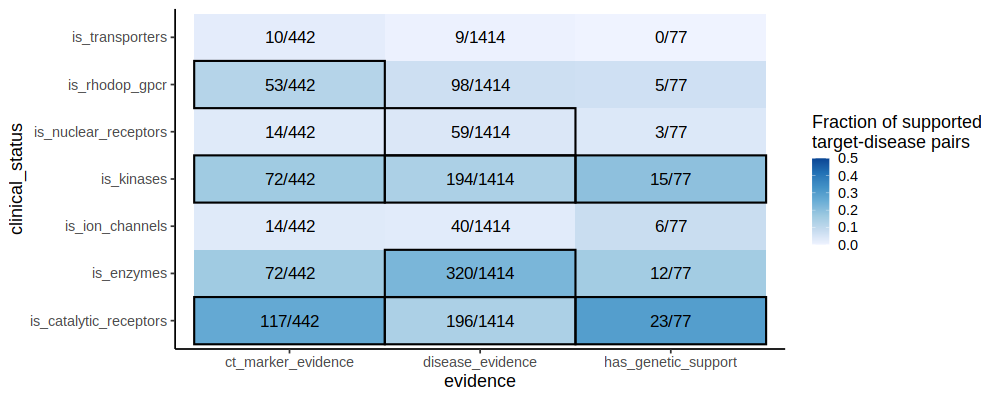

In [503]:
%%R -i res_gr -w 1000 -h 400
res_gr %>%
ggplot(aes(evidence, clinical_status)) +
geom_tile(aes(fill=n_supported_approved/n_supported)) +
geom_text(aes(label=paste0(n_supported_approved, '/', n_supported)), size=6) +
geom_tile(data = . %>% filter(pval < 0.05), color='black', size=1, fill=NA) +
scale_fill_distiller(palette='Blues', direction=1, limits=c(0,0.5), name='Fraction of supported\ntarget-disease pairs') +
theme_classic(base_size=18)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


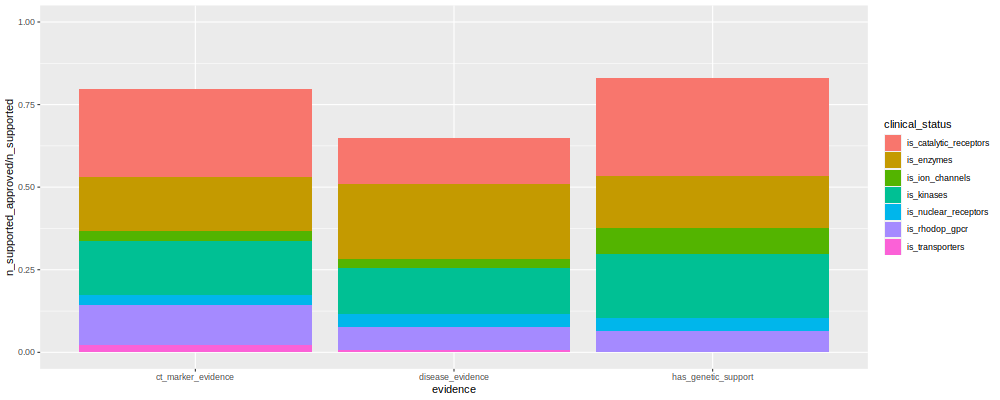

In [504]:
%%R -i res_gr -w 1000 -h 400
res_gr %>%
ggplot(aes(x=evidence)) +
geom_col(aes(y=n_supported_approved/n_supported, fill=clinical_status), position='stack') +
ylim(0,1)

In [643]:
res_gr = pd.DataFrame()
for g in gene_group_cols:
    for clinical_status_col in ['is_safe', 'is_effective', 'is_approved']:
        gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all[clinical_status_col] == 1], evidence_col='ct_marker_evidence', clinical_status_col=g)
        gr_df['group'] = clinical_status_col
        res_gr = pd.concat([res_gr, gr_df])
#         gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all[clinical_status_col] == 1], evidence_col='all_sc_evidence', clinical_status_col=g)
#         gr_df['group'] = clinical_status_col
        res_gr = pd.concat([res_gr, gr_df])
        gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all[clinical_status_col] == 1], evidence_col='disease_evidence', clinical_status_col=g)
        gr_df['group'] = clinical_status_col
        res_gr = pd.concat([res_gr, gr_df])
        gr_df = association_utils.get_OR(targets_evidence_all[targets_evidence_all[clinical_status_col] == 1], evidence_col='has_genetic_support', clinical_status_col=g)
        gr_df['group'] = clinical_status_col
        res_gr = pd.concat([res_gr, gr_df])

Correlate results with class of drugs

In [644]:
n_classes_all = pd.DataFrame()
for c in ['is_safe', 'is_effective', 'is_approved']:
    n_safe = targets_evidence_all[targets_evidence_all[c] == 1].groupby('disease').sum()[gene_group_cols].reset_index()
    n_safe['clinical_status'] = c
    n_classes_all = pd.concat([n_classes_all, n_safe])

/tmp/ipykernel_2097/2600538963.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_safe = targets_evidence_all[targets_evidence_all[c] == 1].groupby('disease').sum()[gene_group_cols].reset_index()
/tmp/ipykernel_2097/2600538963.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_safe = targets_evidence_all[targets_evidence_all[c] == 1].groupby('disease').sum()[gene_group_cols].reset_index()
/tmp/ipykernel_2097/2600538963.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or selec

In [645]:
OR_disease_df = pd.merge(OR_disease_df, n_classes_all, how='left')
pl_df = OR_disease_df.copy()
pl_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,disease_ontology_id,disease_relevant_tissue,disease,is_nuclear_receptors,is_catalytic_receptors,is_rhodop_gpcr,is_transporters,is_kinases,is_enzymes,is_ion_channels
0,2.511832,1.026912,5.348924,0.021918,59.0,19345.0,8.0,1145.0,ct_marker_evidence,is_safe,MONDO_0005097,lung,squamous cell lung carcinoma,2,13,0,0,11,15,0
1,0.569163,0.013907,3.449067,0.828835,29.0,19375.0,1.0,1145.0,ct_marker_evidence,is_effective,MONDO_0005097,lung,squamous cell lung carcinoma,0,4,0,0,3,2,0
2,0.000000,0.000000,6.358635,1.000000,11.0,19393.0,0.0,1145.0,ct_marker_evidence,is_approved,MONDO_0005097,lung,squamous cell lung carcinoma,0,2,0,0,1,0,0
3,1.282831,0.600038,2.508638,0.276811,59.0,19345.0,11.0,2943.0,disease_evidence,is_safe,MONDO_0005097,lung,squamous cell lung carcinoma,2,13,0,0,11,15,0
4,1.781472,0.642196,4.322614,0.138988,29.0,19375.0,7.0,2943.0,disease_evidence,is_effective,MONDO_0005097,lung,squamous cell lung carcinoma,0,4,0,0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2.603206,1.426008,4.510838,0.001099,81.0,19323.0,17.0,1806.0,disease_evidence,is_effective,MONDO_0007915,blood,systemic lupus erythematosus,8,5,2,0,2,9,1
194,1.949801,0.207568,9.159701,0.309028,12.0,19392.0,2.0,1806.0,disease_evidence,is_approved,MONDO_0007915,blood,systemic lupus erythematosus,4,3,1,0,0,4,0
195,2.366364,1.147925,4.399291,0.010389,146.0,19258.0,11.0,652.0,has_genetic_support,is_safe,MONDO_0007915,blood,systemic lupus erythematosus,8,10,3,0,5,14,8
196,1.497076,0.396638,4.009514,0.289469,81.0,19323.0,4.0,652.0,has_genetic_support,is_effective,MONDO_0007915,blood,systemic lupus erythematosus,8,5,2,0,2,9,1


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


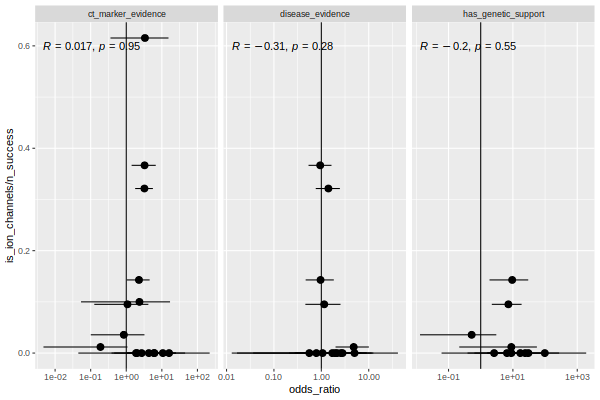

In [646]:
%%R -i pl_df -w 600 -h 400
pl_df %>%
    filter(clinical_status == 'is_approved') %>%
    arrange(is_ion_channels/n_success) %>%
    mutate(disease = factor(disease, levels=unique(disease))) %>%
    ggplot(aes(odds_ratio, is_ion_channels/n_success)) +
    geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        scale_x_log10() +
    geom_vline(xintercept=1) +
    facet_grid(.~evidence, scales='free')+
    ggpubr::stat_cor()

In [647]:
targets_evidence_all['gene_class'] = np.where(
    targets_evidence_all[gene_group_cols].sum(1) > 0,
    targets_evidence_all[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )
    

In [649]:
annos_ensids = {}
for k, gs in annos.items():
    gs_keep = gs[pd.Series(gs).isin(ens_ids_to_name.gene_name)]
    annos_ensids[k] = ens_ids_to_name.set_index('gene_name').loc[gs_keep].values.flatten().tolist()

In [650]:
OR_class_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for u_name, u_list in annos_ensids.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in [ 'ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            OR_class_df = pd.concat([OR_class_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


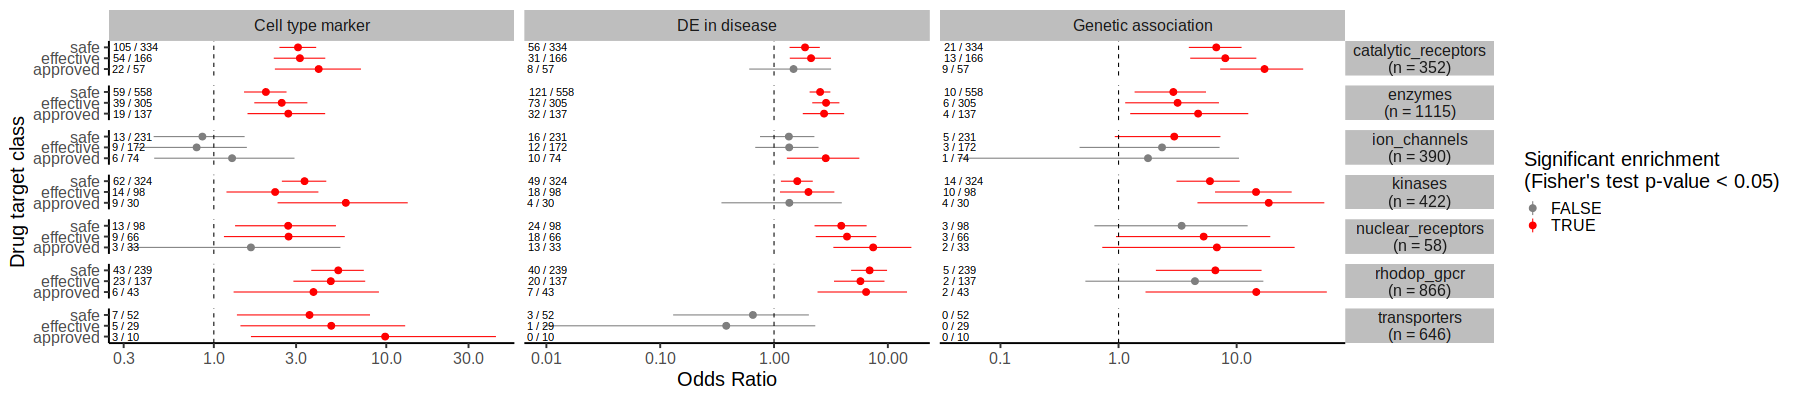

In [651]:
%%R -i OR_class_df -h 400 -w 1800

OR_class_df <- OR_class_df %>%
    filter(evidence %in% c('ct_marker_evidence', 'disease_evidence','has_genetic_support')) %>%
    mutate(u_label = paste0(universe, '\n(n = ', universe_size, ')'))

plot_OR(OR_class_df, 
        text_position='left') +
    facet_grid(u_label~evidence, scales='free_x',
               labeller = labeller(evidence = as_labeller(evidence_labels))) 
#     expand_limits(x=0.05) +
#     ggsave(paste0(figdir, 'OR_results.by_disease.png'), height=18, width=20) +
#     ggsave(paste0(figdir, 'OR_results.by_disease.pdf'), height=18, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


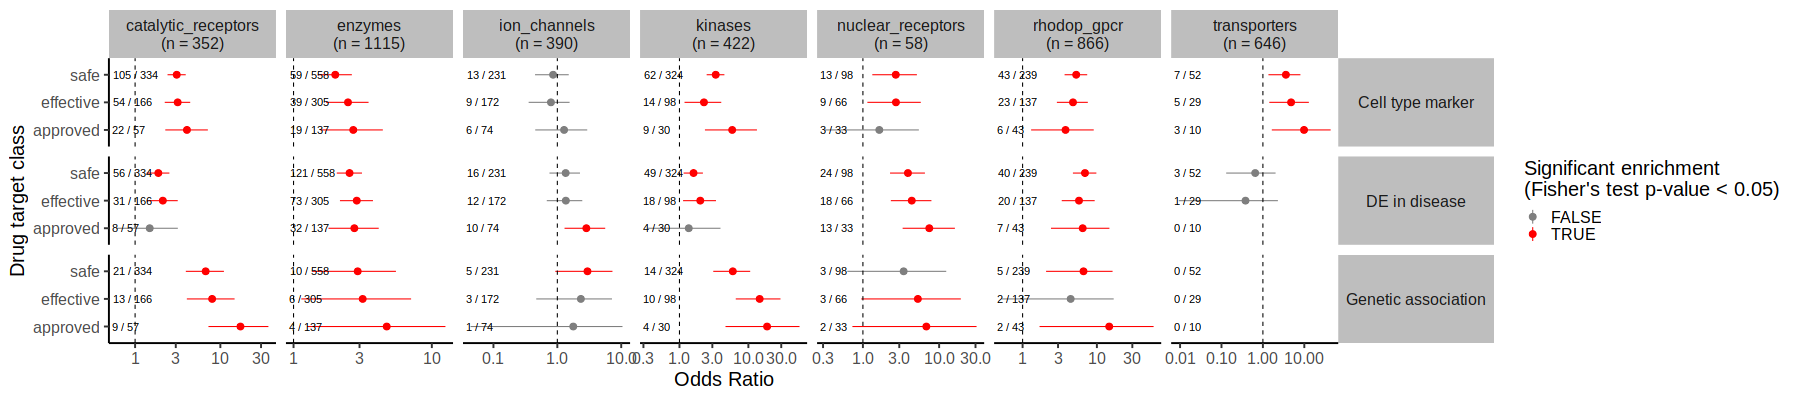

In [652]:
%%R -i OR_class_df -h 400 -w 1800

OR_class_df <- OR_class_df %>%
    filter(evidence %in% c('ct_marker_evidence', 'disease_evidence','has_genetic_support')) %>%
    mutate(u_label = paste0(universe, '\n(n = ', universe_size, ')'))

plot_OR(OR_class_df, 
        text_position='left') +
    facet_grid(evidence~u_label, scales='free_x',
               labeller = labeller(evidence = as_labeller(evidence_labels))) 
#     expand_limits(x=0.05) +
#     ggsave(paste0(figdir, 'OR_results.by_disease.png'), height=18, width=20) +
#     ggsave(paste0(figdir, 'OR_results.by_disease.pdf'), height=18, width=20)

In [219]:
targets_evidence_all[(targets_evidence_all.gene_class == 'nuclear_receptors') & (targets_evidence_all.is_effective==1) & (targets_evidence_all.has_genetic_support==1)]

,Unnamed: 0,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,is_approved,has_genetic_support,...,gene_name,is_nuclear_receptors,is_catalytic_receptors,is_rhodop_gpcr,is_transporters,is_kinases,is_enzymes,is_ion_channels,gene_class,all_sc_evidence
85903,52,ENSG00000091831,MONDO_0005068,0.308356,0.425552,1.0,1.0,1.0,0.0,1.0,...,ESR1,1,0,0,0,0,0,0,nuclear_receptors,0
262778,74,ENSG00000091831,MONDO_0007254,0.649383,0.993878,1.0,1.0,1.0,1.0,1.0,...,ESR1,1,0,0,0,0,0,0,nuclear_receptors,0
362187,144,ENSG00000113580,MONDO_0005002,0.507318,0.996668,1.0,1.0,1.0,1.0,1.0,...,NR3C1,1,0,0,0,0,0,0,nuclear_receptors,0


In [168]:
targets_evidence_all.gene_class.value_counts()

nuclear_receptors      358327
enzymes                 21033
transporters            11869
kinases                  7252
catalytic_receptors      6294
ion_channels             5942
rhodop_gpcr              5188
Name: gene_class, dtype: int64

In [189]:
targets_evidence_all['gene_class']

0                   kinases
1         nuclear_receptors
2                   kinases
3         nuclear_receptors
4         nuclear_receptors
                ...        
415900    nuclear_receptors
415901    nuclear_receptors
415902    nuclear_receptors
415903    nuclear_receptors
415904    nuclear_receptors
Name: gene_class, Length: 415905, dtype: object

### Impact of size of single-cell cohort

In [660]:
# Get number of tested targets x disease
def _ndonors_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=True)
    count_donors = pbulk_adata.obs[['disease', 'donor_id']].drop_duplicates().value_counts('disease')
    n_normal, n_disease = count_donors['normal'], count_donors[count_donors.index != 'normal'][0]
    return(n_normal, n_disease)

In [662]:
targets_evidence_all['n_normal_donors'] = np.nan
targets_evidence_all['n_disease_donors'] = np.nan

for disease_ontology_id in targets_evidence_all.disease_ontology_id.unique():
    try:
        n_normal, n_disease = _ndonors_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_normal_donors'] = n_normal
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_disease_donors'] = n_disease
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    except RuntimeError:
        print(f'missing {disease_ontology_id}')
        continue

missing MONDO_0015517


In [663]:
n_donors_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()
n_donors_by_disease = pd.merge(n_donors_by_disease, targets_evidence_all[['n_normal_donors', 'n_disease_donors', 'disease_ontology_id']].drop_duplicates())

/tmp/ipykernel_2097/1400024238.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_donors_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()


In [664]:
data = pd.merge(OR_disease_df, n_donors_by_disease)
# sns.scatterplot(x=np.log10(data['n_normal_donors']), y=np.log(data['odds_ratio']));
# plt.show()

In [665]:
n_donors_by_disease.sort_values('disease_evidence')

,disease_ontology_id,ct_marker_evidence,disease_evidence,n_normal_donors,n_disease_donors
14,MONDO_0005147,821.0,24.0,30.0,5.0
5,MONDO_0004849,1166.0,42.0,190.0,3.0
2,MONDO_0002771,1167.0,124.0,190.0,6.0
3,MONDO_0004298,1355.0,142.0,28.0,9.0
7,MONDO_0004970,1493.0,151.0,48.0,4.0
27,MONDO_0015925,1170.0,198.0,190.0,6.0
6,MONDO_0004966,1355.0,266.0,28.0,5.0
23,MONDO_0010811,895.0,412.0,10.0,7.0
22,MONDO_0009061,1187.0,429.0,190.0,21.0
24,MONDO_0013662,511.0,895.0,22.0,7.0


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


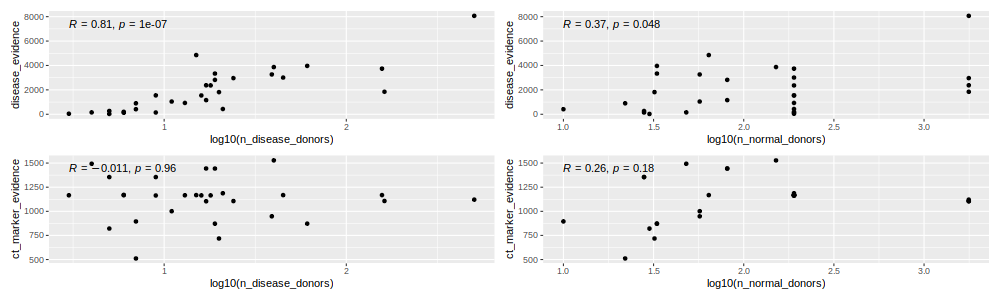

In [666]:
%%R -i n_donors_by_disease -w 1000 -h 300
pl1 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), disease_evidence)) +
geom_point() +
ggpubr::stat_cor()
pl2 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), disease_evidence)) +
geom_point() +
ggpubr::stat_cor()
pl3 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), ct_marker_evidence)) +
geom_point() +
ggpubr::stat_cor()
pl4 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), ct_marker_evidence)) +
geom_point() +
ggpubr::stat_cor()

(pl1 | pl2) / (pl3 | pl4)

In [667]:
n_donors_by_disease[n_donors_by_disease['n_disease_donors'] > n_donors_by_disease['n_normal_donors']]

,disease_ontology_id,ct_marker_evidence,disease_evidence,n_normal_donors,n_disease_donors
8,MONDO_0004994,872.0,3962.0,33.0,61.0


In [668]:
%%R -i data -w 1000 -h 300
data %>%
filter(evidence == 'disease_evidence') %>%
arrange(n_disease_donors) %>%
mutate(disease = factor(disease, levels=unique(disease))) %>%
filter(disease == 'pulmonary emphysema')

    odds_ratio    ci_low  ci_high       pval n_success n_insuccess
111   24.21349 0.5713073 158.5795 0.04331986        22       19382
112   46.20445 1.0484279 332.7195 0.02386059        12       19392
113    0.00000 0.0000000 770.0364 1.00000000         4       19400
    n_supported_approved n_supported         evidence clinical_status
111                    1          39 disease_evidence         is_safe
112                    1          39 disease_evidence    is_effective
113                    0          39 disease_evidence     is_approved
    disease_ontology_id disease_relevant_tissue             disease
111       MONDO_0004849                    lung pulmonary emphysema
112       MONDO_0004849                    lung pulmonary emphysema
113       MONDO_0004849                    lung pulmonary emphysema
    is_nuclear_receptors is_catalytic_receptors is_rhodop_gpcr is_transporters
111                    4                      1              3               0
112                   

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


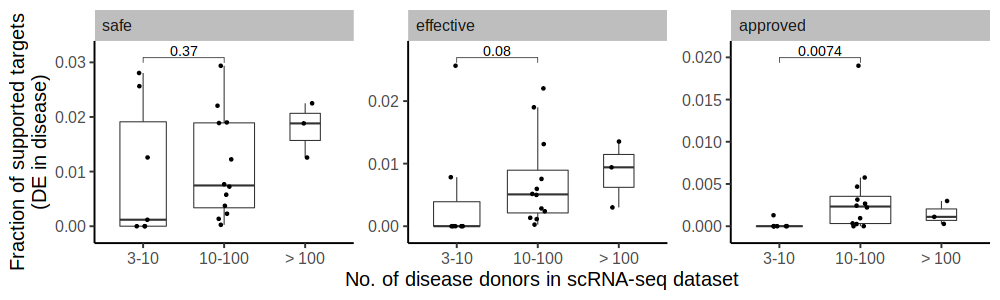

In [669]:
%%R -i data -w 1000 -h 300
my_comparisons <- list( c('3-10', "10-100"))
data %>%
filter(evidence == 'disease_evidence') %>%
arrange(n_disease_donors) %>%
# filter(disease != 'pulmonary emphysema') %>%
mutate(disease = factor(disease, levels=unique(disease))) %>%
mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
mutate(n_disease_donors_bin = cut(log10(n_disease_donors), breaks=c(0,1,2,3), labels=c('3-10', '10-100', '> 100'))) %>%
# mutate(n_disease_donors_bin = ifelse(n_disease_donors <= 10, '< 10', '> 10')) %>%
ggplot(aes(
    as.factor(n_disease_donors_bin),
    n_supported_approved/n_supported
#     log(odds_ratio)
          )) +
geom_boxplot(varwidth=TRUE, outlier.alpha=0) +
geom_jitter(width=0.1) +
xlab('No. of disease donors in scRNA-seq dataset') +
ylab('Fraction of supported targets\n(DE in disease)') +
ggpubr::stat_compare_means(comparisons = my_comparisons, size=5, method='wilcox.test', format='p.format', ) +
facet_wrap(clinical_status~., scales='free') +
theme_classic(base_size=20) + 
scale_y_continuous(expand=expansion(mult = c(0.1, .1))) +
theme(strip.text = element_text(hjust = 0), strip.background=element_rect(color=NA, fill='grey'),
                                    panel.spacing=unit(1,"lines")
                                   )

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


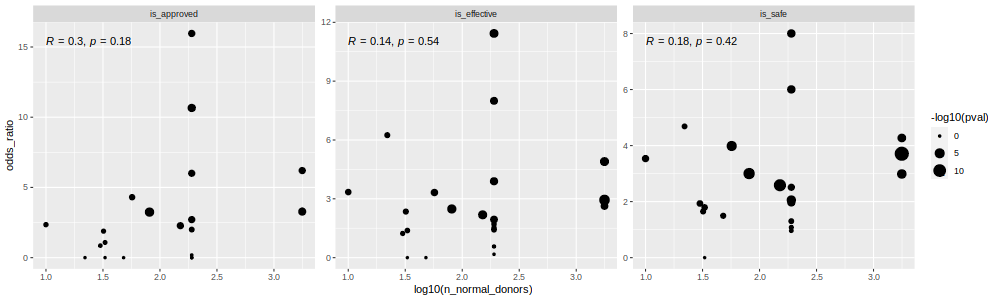

In [322]:
%%R -i data -w 1000 -h 300
data %>%
filter(evidence == 'ct_marker_evidence') %>%
ggplot(aes(log10(n_normal_donors), odds_ratio, size=-log10(pval))) +
geom_point() +
facet_wrap(clinical_status~., scales='free') +
ggpubr::stat_cor()

In [492]:
data.columns

Index(['odds_ratio', 'ci_low', 'ci_high', 'pval', 'n_success', 'n_insuccess',
       'n_supported_approved', 'n_supported', 'evidence', 'clinical_status',
       'disease_ontology_id', 'disease_relevant_tissue', 'disease',
       'is_nuclear_receptors', 'is_catalytic_receptors', 'is_rhodop_gpcr',
       'is_transporters', 'is_kinases', 'is_enzymes', 'is_ion_channels',
       'ct_marker_evidence', 'disease_evidence', 'n_normal_donors',
       'n_disease_donors'],
      dtype='object')

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,...,is_catalytic_receptors,is_rhodop_gpcr,is_transporters,is_kinases,is_enzymes,is_ion_channels,ct_marker_evidence,disease_evidence,n_normal_donors,n_disease_donors
0,1.652357,0.951488,2.849619,0.037931,59.0,19345.0,27.0,6566.0,disease_ct_evidence,is_safe,...,13,0,0,11,15,0,1168.0,9303.0,190.0,45.0
1,1.826577,0.816337,4.061547,0.076203,29.0,19375.0,14.0,6566.0,disease_ct_evidence,is_effective,...,4,0,0,3,2,0,1168.0,9303.0,190.0,45.0
2,2.347388,0.596639,9.727047,0.129751,11.0,19393.0,6.0,6566.0,disease_ct_evidence,is_approved,...,2,0,0,1,0,0,1168.0,9303.0,190.0,45.0
3,2.511832,1.026912,5.348924,0.021918,59.0,19345.0,8.0,1145.0,ct_marker_evidence,is_safe,...,13,0,0,11,15,0,1168.0,9303.0,190.0,45.0
4,0.569163,0.013907,3.449067,0.828835,29.0,19375.0,1.0,1145.0,ct_marker_evidence,is_effective,...,4,0,0,3,2,0,1168.0,9303.0,190.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.626720,0.260506,1.303142,0.929067,81.0,19323.0,8.0,2884.0,bulk_disease_evidence,is_effective,...,5,2,0,2,9,1,1107.0,7313.0,1770.0,162.0
326,1.145724,0.121999,5.380330,0.551242,12.0,19392.0,2.0,2884.0,bulk_disease_evidence,is_approved,...,3,1,0,0,4,0,1107.0,7313.0,1770.0,162.0
327,2.366364,1.147925,4.399291,0.010389,146.0,19258.0,11.0,652.0,has_genetic_support,is_safe,...,10,3,0,5,14,8,1107.0,7313.0,1770.0,162.0
328,1.497076,0.396638,4.009514,0.289469,81.0,19323.0,4.0,652.0,has_genetic_support,is_effective,...,5,2,0,2,9,1,1107.0,7313.0,1770.0,162.0


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


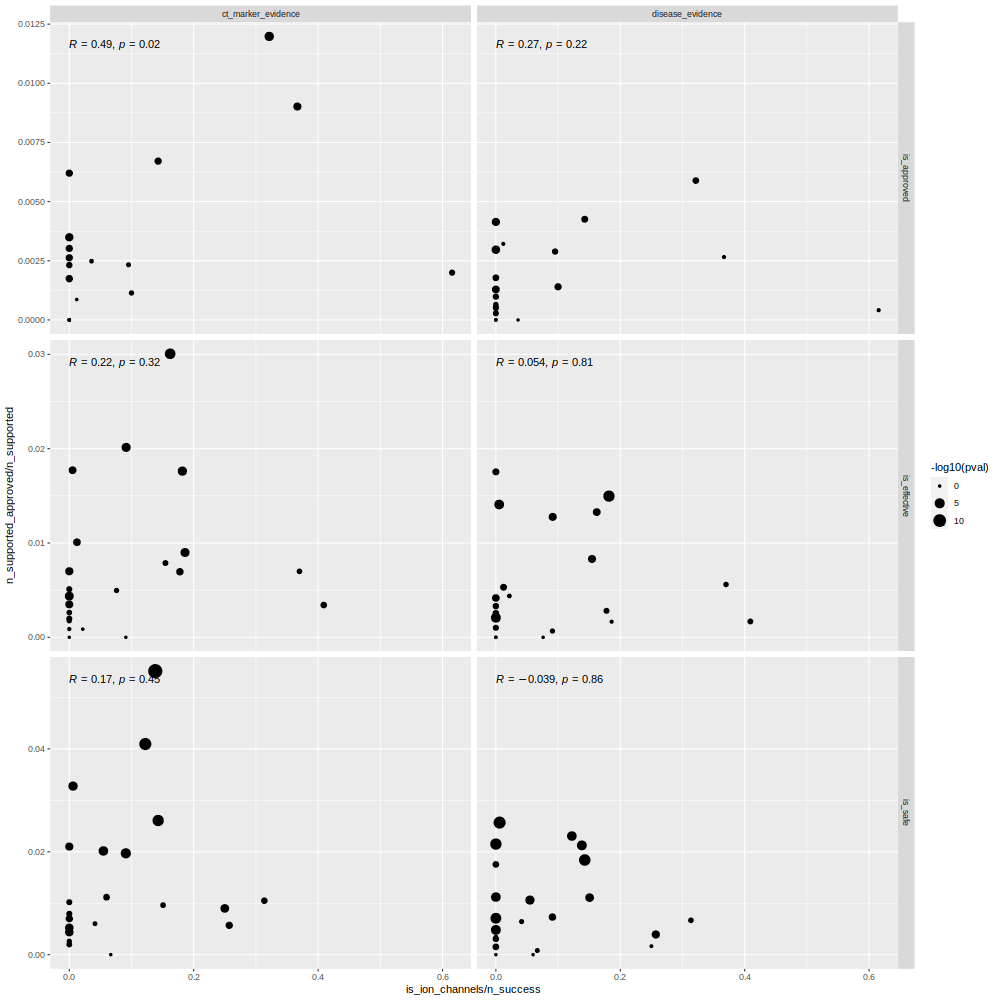

In [499]:
%%R -i data -w 1000 -h 1000
data %>%
filter(evidence %in% c('ct_marker_evidence', 'disease_evidence')) %>%
ggplot(aes(is_ion_channels/n_success, n_supported_approved/n_supported, size=-log10(pval))) +
geom_point() +
facet_grid(clinical_status~evidence, scales='free') +
ggpubr::stat_cor()